In [6]:
import os
import numpy as np
import matplotlib as mpl
from matplotlib import pyplot as plt

plt.rc('text', usetex=True)
plt.rc('font', family='serif')
plt.rc('figure', dpi=300)

from scipy.integrate import solve_ivp
from multiprocessing.pool import Pool
from astropy import constants as const
from astropy import units as u

from rebound import Simulation
import pandas as pd
from scipy.stats import ks_2samp
from scipy.optimize import curve_fit
from functions import HW99

color_A = '#005AB5'
color_B = '#DC3220'
color_C = '#FFB000'

R_sun = (u.R_sun).to('AU')

def p2a(P, M):
    ''' P (days), M (M_sun) ''' 
    a3 = const.GM_sun*M*(P*u.day/np.pi)**2/4
    return np.cbrt(a3).to('AU').value

def a2p(a, M):
    ''' a (AU), M (M_sun) '''
    P = 2*np.pi*np.sqrt((a*u.AU)**3/const.G/(u.M_sun*M))
    return P.to('day').value

def init(M_A: float, M_B: float, a_bin: float, a_p: float, 
         inc_bin: float, inc_p: float, Omega_bin: float = 0,
         Omega_p: float = 0, e_B: float = 0, e_p: float = 0,
         omega: float = 0) -> Simulation:

    sim = Simulation()
    sim.add(m=M_A)
    sim.add(m=M_B, a=a_bin, inc=inc_bin, 
            Omega=Omega_bin, e=e_B, omega=omega)
    sim.add(a=a_p, inc=inc_p, Omega=Omega_p, e=e_p)
    sim.move_to_com()
    sim.ri_ias15.min_dt = 1e-3
    
    return sim

def integrate(sim: Simulation, P: float = None, 
              N: float = None) -> tuple[np.array]:
    if not P:
        P = sim.particles[2].P
    if N:
        P *= N
    x, y, z, dt = ([[] for _ in range(sim.N)], 
                   [[] for _ in range(sim.N)], 
                   [[] for _ in range(sim.N)], 
                   [])
    while sim.t < P:
        sim.step()
        for i, p in enumerate(sim.particles):
            x[i].append(p.x)
            y[i].append(p.y)
            z[i].append(p.z)
            dt.append(sim.dt)
    x, y, z = np.array(x), np.array(y), np.array(z)
    sim = None
    return x, y, z

def plot_system(M_A: float, M_B: float, a: float, r_a: float, 
                inc: float, Omega_p: float = 0, Omega_b: float = 0, e: float = 0, 
                omega: float = 0, N: float = None, dinc: float = 0, 
                fancy: bool = False, xlim: float = 0.5,  
                ylim: float = 0.5, offset: int = None, title: str = None) ->  None:
  
    sim = init(M_A, M_B, a, r_a*a, np.deg2rad(inc), 
               np.deg2rad(inc+dinc), np.deg2rad(Omega_b),
               np.deg2rad(Omega_p), e, omega=np.deg2rad(omega))
    x, y, z = integrate(sim, N=N)
    
    if not fancy:
        fig = plt.figure()
    else: fig = plt.figure(figsize=(7, 3))
    ax = fig.add_subplot()
    ax.plot(x[0], z[0], c='r', lw=1, alpha=0.7)
    ax.plot(x[1], z[1], c='b', lw=1, alpha=0.7)
    ax.plot(x[2], z[2], c='k', lw=1, alpha=0.7)
    
    if fancy:
        try:    
            center = abs(x[2]) - min(x[2], key=abs)
            cond = (center<0.02) & (z[2]<=0)
            p_z = z[2, cond][0]
            planet = (0, p_z)
            planet = plt.Circle(planet, 0.01, color='black', label='Planet')
            ax.add_artist( planet )
        except:
            print('no planet')

        idx = np.extract(abs(x[0]) == abs(x[0]).min(), 
                         np.arange(x[0].size)) + offset

        _x = x[0][idx]
        _z = z[0][idx]
        A = (_x, _z)
        A = plt.Circle(A, 0.03, color='red',
                       alpha=0.25, label='Star A')

        _x = x[1][idx]
        _z = z[1][idx]
        B = (_x, _z)
        B = plt.Circle(B, radius=0.03, color='blue', 
                       alpha=0.25, label='Star B')
        
        ax.add_artist( A )
        ax.add_artist( B )
        
        ax.axis('scaled')
        ax.set_xlim(-xlim, xlim)
        ax.set_ylim(-ylim, ylim)
        ax.legend(loc='upper left', fontsize='small')

    ax.grid(True)
    if title is None: title = "View of the System along the z-axis"
    # ax.axis('scaled')
    ax.set_title(title)
    ax.set_xlabel("x [AU]", fontsize='large')
    ax.set_ylabel("y [AU]", fontsize='large')
    # plt.axis(False)
    plt.show()

def fOmega(e):
    return (1+3*e**2+3/8*e**4)/(1-e**2)**(9/2)
def fOmega_e(e):
    return (1+3/2*e**2+1/8*e**4)/(1-e**2)**5
def fN(e):
    return (1+15/2*e**2+45/8*e**4+5/16*e**6)/(1-e**2)**6
def fN_e(e):
    return (1+15/4*e**2+15/8*e**4+5/64*e**6)/(1-e**2)**(13/2)
def fN_a(e):
    return (1+31/2*e**2+255/8*e**4+185/16*e**6+25/64*e**8)/(1-e**2)**(15/2)
def F_e(e):
    return (fOmega_e(e)*fN(e)/fOmega(e))-18*fN_e(e)/11
def F_a(e):
    return 4/11*(fN(e)**2/fOmega(e)-fN_a(e))

def tidal_circ(t, orb, mu, eta):
	e, P = orb
	tc = 0.3*(P/6.)**eta
	dedt = e*mu*(1.+mu)/tc*F_e(e)
	dPdt = 1.5*P*mu*(1.+mu)/tc*F_a(e)
	return [dedt,dPdt]

def solve_circularization(inp):
    e, P, mu, eta = inp
    t_age = np.random.default_rng().uniform(1, 10)
    sol = solve_ivp(tidal_circ, (0, t_age), (e, P), t_eval=[t_age], 
                    args=(mu, eta), method='LSODA')
    return sol.y.flatten()

def roche_limit(mu, e, P):
    return 0.44*mu**-0.33/(1+1/mu)**0.2 * p2a(P, 1)*(1-e)

def binary_pop(eta, N: int = 1_000):
    e = np.random.default_rng().beta(1.75, 2.01, N)
    P_min, P_max = 1, 200
    l = np.random.default_rng().triangular(0, 1, 1, N)
    P = P_max**l*P_min**(1-l)
    mu = np.random.default_rng().triangular(0, 1, 1, N)

    roche_mask_A = R_sun >= roche_limit(1/mu, e, P)
    roche_mask_B = R_sun*mu**0.8 >= roche_limit(mu, e, P)
    s = ~(roche_mask_A | roche_mask_B)

    eta = np.full_like(e, eta)
    inp = np.array((e, P, mu, eta)).T

    with Pool() as pool:
        ec, Pc, _ = np.array(pool.map(solve_circularization, inp)).T
    return ec, Pc, e, P, mu, s

def read_df(fname, key: str='data'):
    with pd.HDFStore(fname) as hdf:
        return hdf[key]

In [2]:
a, b = 0.5, 3

# plot_system(M_A=1, M_B=1, a=a, r_a=b, inc=15, e=0.1, 
#             Omega_b=80, Omega_p=55, omega=90, dinc=-10,
#             fancy=True, xlim=0.5, ylim=0.2, offset=5,
#             title='System before Tidal Migration')
# plot_system(M_A=1, M_B=1, a=0.5*a, r_a=2*b, inc=15, e=0, 
#             Omega_b=80, Omega_p=55, omega=90, dinc=-10,
#             fancy=True, xlim=0.5, ylim=0.2, offset=3,
#             title='System after Tidal Migration')

In [7]:
from shapely.plotting import plot_line, plot_polygon
from shapely import LineString

def continuous_segments(arr, segment_mask):
    segments = []
    
    start_indices = np.where(segment_mask & ~np.roll(segment_mask, 1))[0]
    end_indices = np.where(~segment_mask & np.roll(segment_mask, 1))[0]
    
    if segment_mask[0]:
        start_indices = np.concatenate(([0], start_indices))
    if segment_mask[-1]:
        end_indices = np.concatenate((end_indices, [len(arr)]))
    
    for start_idx, end_idx in zip(start_indices, end_indices):
        segments.append(arr[start_idx:end_idx])
    
    return segments

def plot_system(M_A: float, M_B: float, a: float, r_a: float, inc: float, 
                Omega_p: float = 0, Omega_b: float = 0, e: float = 0, 
                omega: float = 0, N: float = None, dinc: float = 0, 
                xlim: float = 0.5, ylim: float = 0.5, offset: int = 0,
                text: str = '') ->  None:
  
    sim = init(M_A, M_B, a, r_a*a, np.deg2rad(inc), 
               np.deg2rad(inc+dinc), np.deg2rad(Omega_b),
               np.deg2rad(Omega_p), e, omega=np.deg2rad(omega))
    x, y, z = integrate(sim, N=N)
    
    fig = plt.figure(layout='constrained')
    ax = fig.add_subplot()
    lw = 1

    line_A = LineString(np.transpose((x[0], z[0])))
    plot_line(line_A, ax=ax, add_points=False, linewidth=lw, color=color_A, linestyle='--')
    dilated_A = line_A.buffer(0.015, cap_style=1)
    plot_polygon(dilated_A, ax=ax, add_points=False, alpha=0.3, color=color_A)

    line_B = LineString(np.transpose((x[1], z[1])))
    plot_line(line_B, ax=ax, add_points=False, linewidth=lw, color=color_B, linestyle='--')
    dilated_B = line_B.buffer(0.02*M_B**0.8, cap_style=1)
    plot_polygon(dilated_B, ax=ax, add_points=False, alpha=0.3, color=color_B)

    ax.plot(x[2], z[2], c='k', lw=lw, alpha=0.7, ls='--')
    x_segments = continuous_segments(x[2], y[2]<0)
    z_segments = continuous_segments(z[2], y[2]<0)
    for _x, _z in zip(x_segments, z_segments):
        ax.plot(_x, _z, lw=lw, c='k')

    A = (x[0][offset], z[0][offset])
    A = plt.Circle(A, 0.015, color=color_A, alpha=1)
    ax.add_artist(A)

    B = (x[1][offset], z[1][offset])
    B = plt.Circle(B, 0.015, color=color_B, alpha=1)
    ax.add_artist(B)

    planet = (x[2][offset], z[2][offset])
    planet = plt.Circle(planet, 0.005, color='black')
    ax.add_artist(planet)

    ax.axis('scaled')
    ax.set_xlim(-xlim, xlim)
    ax.set_ylim(-ylim, ylim)
    # ax.text(xlim-0.01, -ylim+0.015, text, ha='right', fontsize=18)
    plt.tick_params(axis='both',         
                    which='both',     
                    bottom=False,    
                    top=False,       
                    left=False,
                    right=False,
                    labelleft=False,
                    labelbottom=False)
    
    plt.show()

offset = 212
# plot_system(M_A=1, M_B=0.9, a=0.5, r_a=4, inc=15, e=0.2, 
#             Omega_b=45, Omega_p=2, omega=80, dinc=-10, 
#             xlim=0.35, ylim=0.2, offset=225, N=1, text='No Transits')
# plot_system(M_A=1, M_B=0.9, a=0.5, r_a=4, inc=15, e=0.2, 
#             Omega_b=45, Omega_p=23, omega=80, dinc=-12, 
#             xlim=0.35, ylim=0.2, offset=211, N=1, text='Transits 1 Star')
# plot_system(M_A=1, M_B=0.9, a=0.5, r_a=4, inc=15, e=0.2, 
#             Omega_b=45, Omega_p=23, omega=80, dinc=-13, 
#             xlim=0.35, ylim=0.2, offset=209, N=1, text='Transits Both Stars')

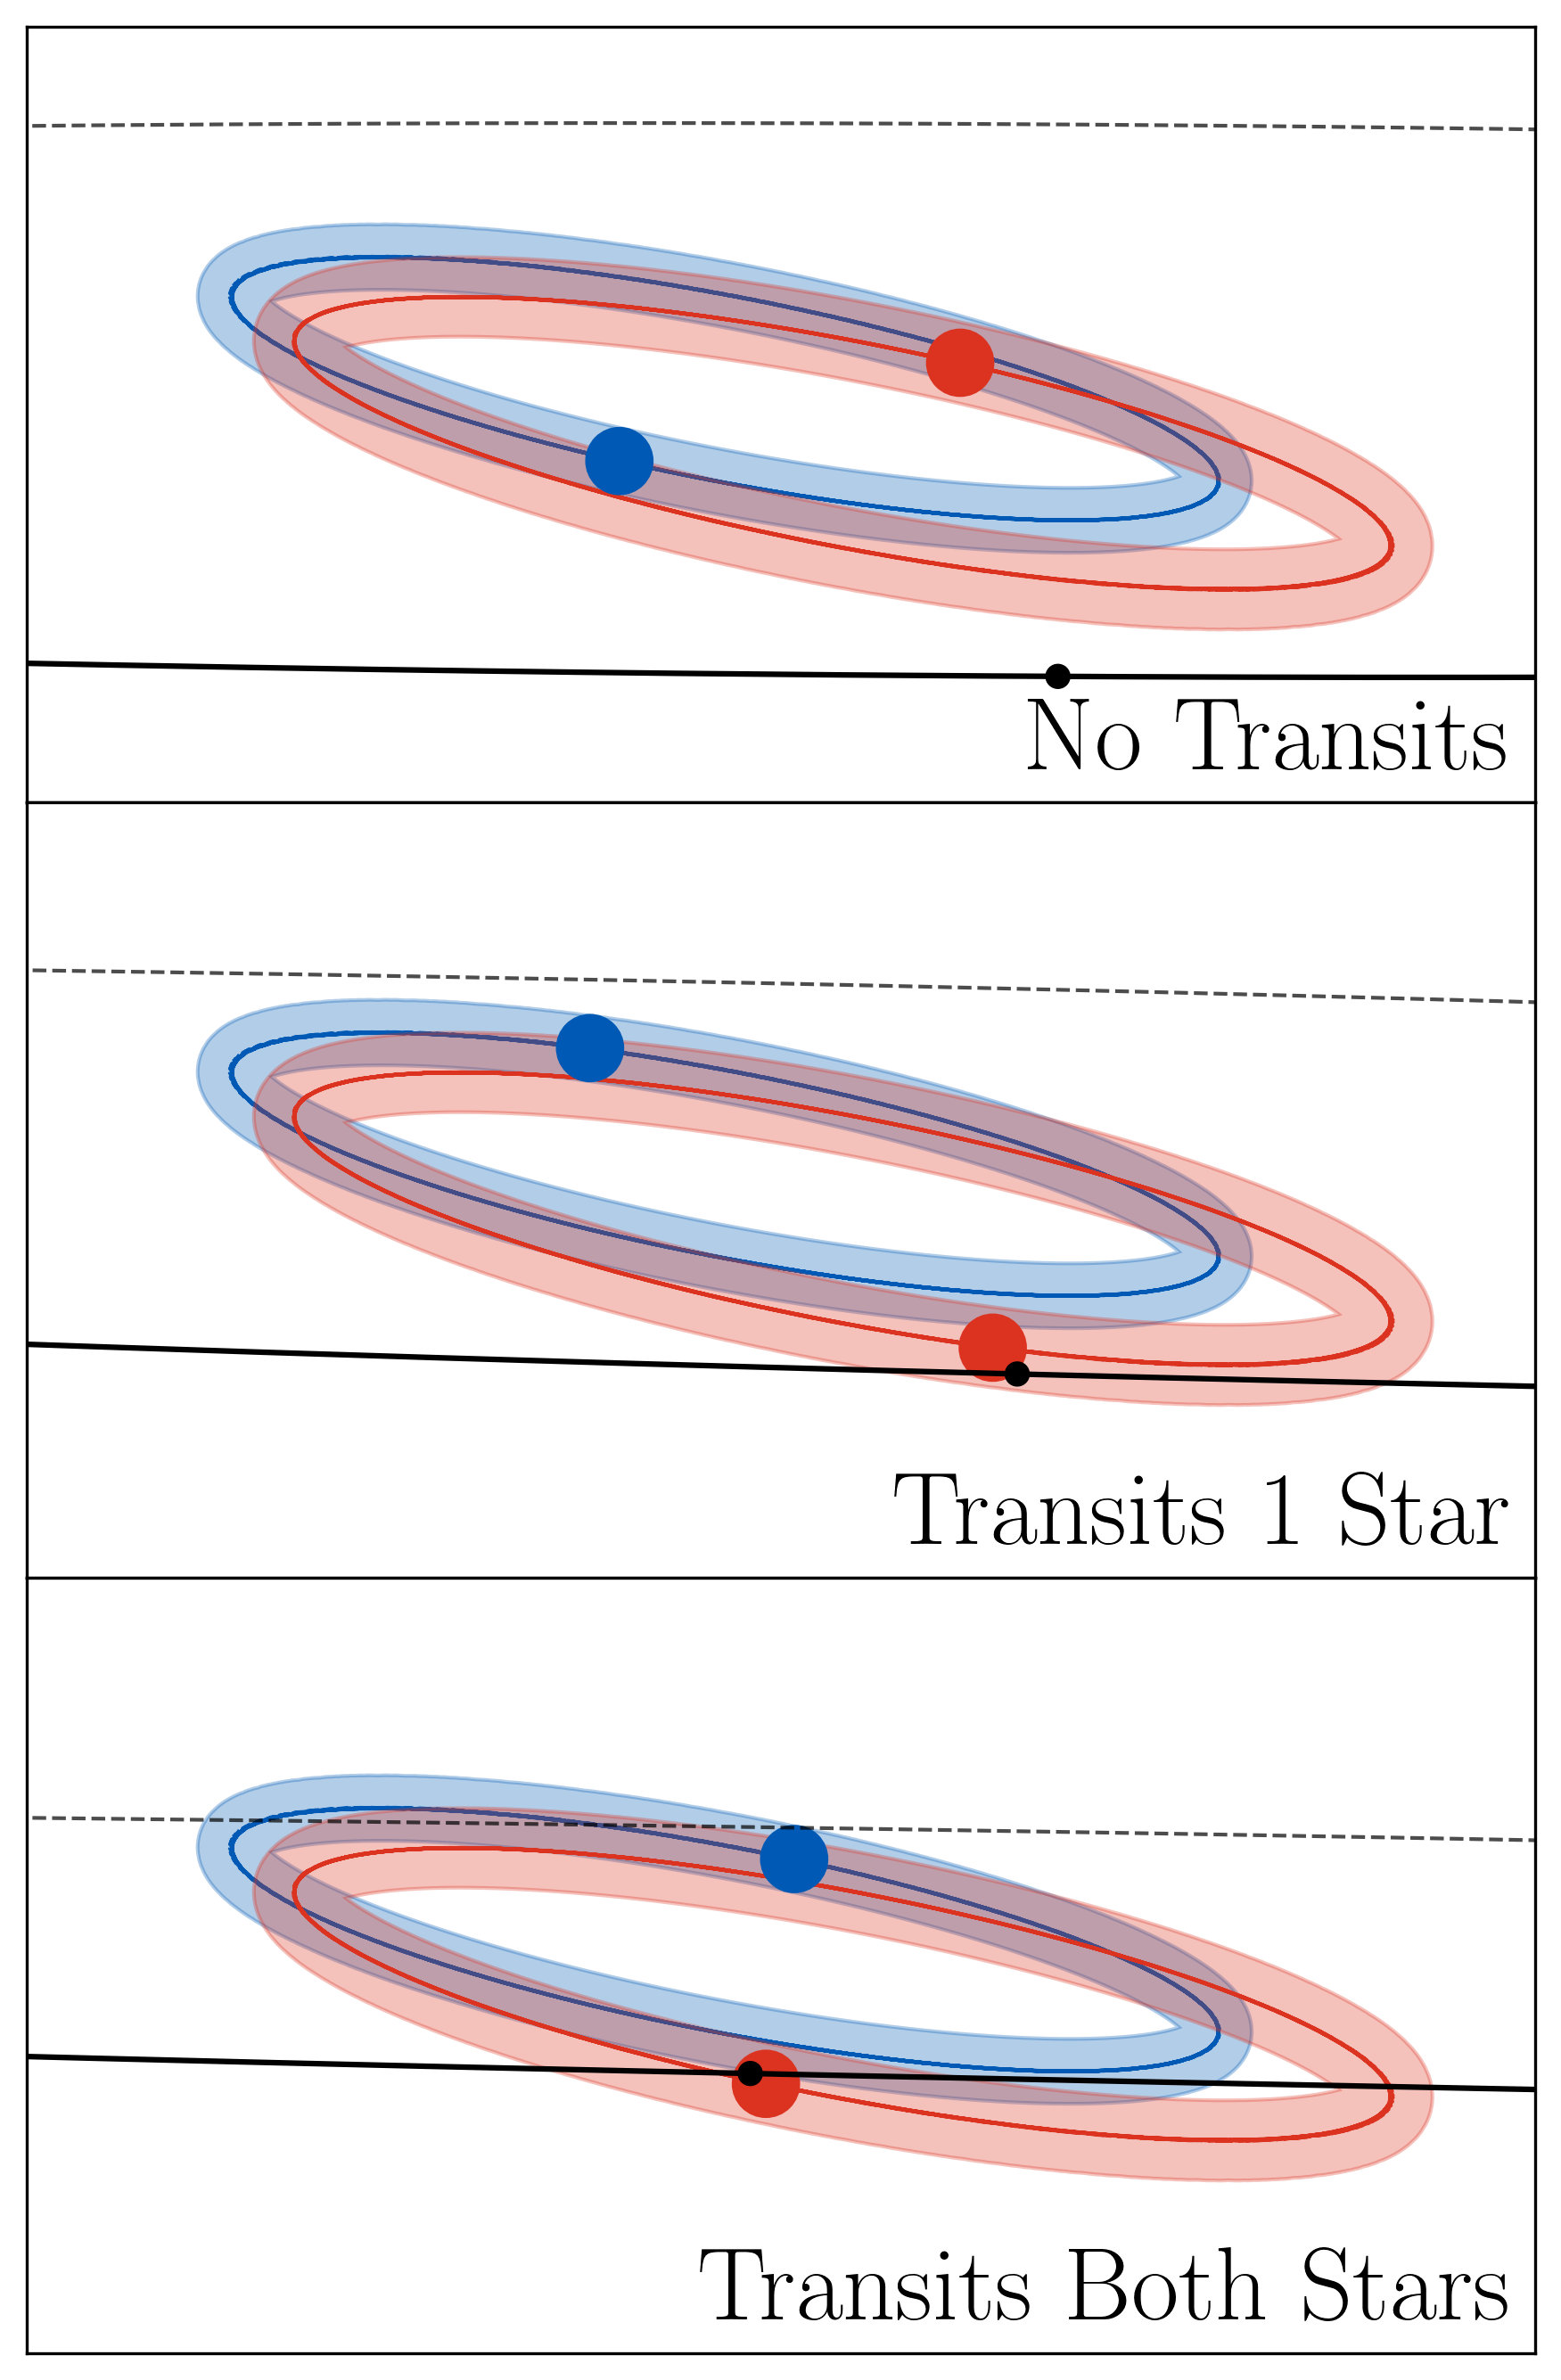

In [83]:
M_A=1
M_B=0.9
a=0.5
r_a=4
inc=15
e=0.2
Omega_b=45
Omega_p=(2, 23, 23)
omega=80
dinc=(-11, -12, -13)
xlim=0.35
ylim=0.18
offset=(225, 211, 209)
N=1#2
text=('No Transits', 'Transits 1 Star', 'Transits Both Stars')
lw = 1

fig = plt.figure(figsize=(6, 9), layout='tight')
gs = fig.add_gridspec(3, hspace=0)
axes = gs.subplots(sharex=True)

for ax, op, di, of, tx in zip(axes, Omega_p, dinc, offset, text):

    sim = init(M_A, M_B, a, r_a*a, np.deg2rad(inc), 
                np.deg2rad(inc+di), np.deg2rad(Omega_b),
                np.deg2rad(op), e, omega=np.deg2rad(omega))
    x, y, z = integrate(sim, N=N)

    line_A = LineString(np.transpose((x[0], z[0])))
    plot_line(line_A, ax=ax, add_points=False, linewidth=lw, color=color_A, linestyle='--')
    dilated_A = line_A.buffer(0.015, cap_style=1)
    plot_polygon(dilated_A, ax=ax, add_points=False, alpha=0.3, color=color_A)

    line_B = LineString(np.transpose((x[1], z[1])))
    plot_line(line_B, ax=ax, add_points=False, linewidth=lw, color=color_B, linestyle='--')
    dilated_B = line_B.buffer(0.02*M_B**0.8, cap_style=1)
    plot_polygon(dilated_B, ax=ax, add_points=False, alpha=0.3, color=color_B)

    ax.plot(x[2], z[2], c='k', lw=lw, alpha=0.7, ls='--')
    x_segments = continuous_segments(x[2], y[2]<0)
    z_segments = continuous_segments(z[2], y[2]<0)
    for _x, _z in zip(x_segments, z_segments):
        ax.plot(_x, _z, lw=lw+0.5, c='k')

    A = (x[0][of], z[0][of])
    A = plt.Circle(A, 0.015, color=color_A, alpha=1)
    ax.add_artist(A)

    B = (x[1][of], z[1][of])
    B = plt.Circle(B, 0.015, color=color_B, alpha=1)
    ax.add_artist(B)

    planet = (x[2][of], z[2][of])
    planet = plt.Circle(planet, 0.005, color='black')
    ax.add_artist(planet)

    ax.axis('scaled')
    ax.set_xlim(-xlim, xlim)
    ax.set_ylim(-ylim, ylim)
    ax.text(xlim-0.01, -ylim+0.015, tx, ha='right', fontsize=28)
    ax.tick_params(axis='both',         
                    which='both',     
                    bottom=False,    
                    top=False,       
                    left=False,
                    right=False,
                    labelleft=False,
                    labelbottom=False)
    
plt.show()

In [84]:
def full_binary_pop(n_pop: int, eta: float=4.5):
    rng = np.random.default_rng()
    e = rng.beta(1.75, 2.01, n_pop)

    P_min, P_max = 3, 200
    l = rng.triangular(0, 1, 1, n_pop)
    P = P_max**l*P_min**(1-l)

    mu = rng.triangular(0, 1, 1, n_pop)
    eta = np.full_like(e, eta)
    inp = np.array((e, P, mu, eta)).T

    with Pool() as pool:
        e_circ, P_circ = np.array(pool.map(solve_circularization, inp)).T

    UPPER_ANGLE = 30
    arg = np.sin(np.deg2rad(UPPER_ANGLE))
    i = np.arcsin(rng.uniform(0, arg, n_pop)) + np.pi/2
    omega = rng.uniform(0, 2*np.pi, n_pop)
    Omega = rng.uniform(0, 2*np.pi, n_pop)

    r_a = R_sun
    r_b = R_sun*mu**0.8
    a = p2a(P_circ, 1)

    corr = (1-np.abs(e_circ*np.cos(omega)))/(1-e_circ**2)
    eclipsing = abs(np.sin(i-np.pi/2)) <= (r_a+r_b)/a * corr

    roche_limit = 0.44*mu**-0.33/(1+1/mu)**0.2
    pericenter = a*(1-e_circ)
    stable = r_a < roche_limit*pericenter

    data = {'eccentricity': e, 'period': P, 'mass_ratio': mu,
            'circ_eccentricity': e_circ, 'circ_period': P_circ,
            'inclination': np.rad2deg(i), 'omega': omega, 'Omega': Omega,
            'radius_a': r_a, 'radius_b': r_b, 'semimajor_axis': a,
            'eclipsing?': eclipsing, 'stable?': stable}
    
    return pd.DataFrame(data=data)

windemuth = pd.read_csv('data/windemuth.posteriors', sep=' ', header=1)
theory = full_binary_pop(100_000, 4.5)

In [6]:
s, lw, fs, density = 5, 0.5, 16, False
pmin, pmax = 0.25, 200
data = theory[theory['eclipsing?'] & theory['stable?']]
fig, ax = plt.subplots(2, 1, figsize=(7, 6), sharex=True, layout='tight')

ax[0].scatter(data['circ_period'], data['circ_eccentricity'], s=s, 
              linewidths=lw, edgecolors='#a12033', facecolors='none',
              label='Circularized')
ax[0].scatter(data['period'], data['eccentricity'], s=s, edgecolors='k', 
              label='Initial', facecolors='none', linewidths=lw, alpha=0.2)
ax[0].set_ylim(0, 1)
ax[0].set_ylabel('$e$', fontsize=fs)
ax[0].legend(loc=2)
ax[0].grid()

nbins = 20
bins = np.logspace(np.log10(pmin), np.log10(pmax))
ax[1].hist(data['circ_period'], bins=bins, histtype='step', 
           label='Circularized', color='#a12033', density=density)
ax[1].hist(data['period'], bins=bins, histtype='step', 
           color='k', label='Initial', density=density)
ax[1].set_ylabel('Number of Systems', fontsize=fs)
ax[1].legend(loc=2)
ax[1].grid()

fig.suptitle('Initial and Circularized Eclipsing Binary Distributions', 
             fontsize=fs)
plt.xscale('log')
plt.xlim(pmin, pmax)
plt.xlabel('$P_{b}$ [log(day)]', fontsize=fs)
plt.close()

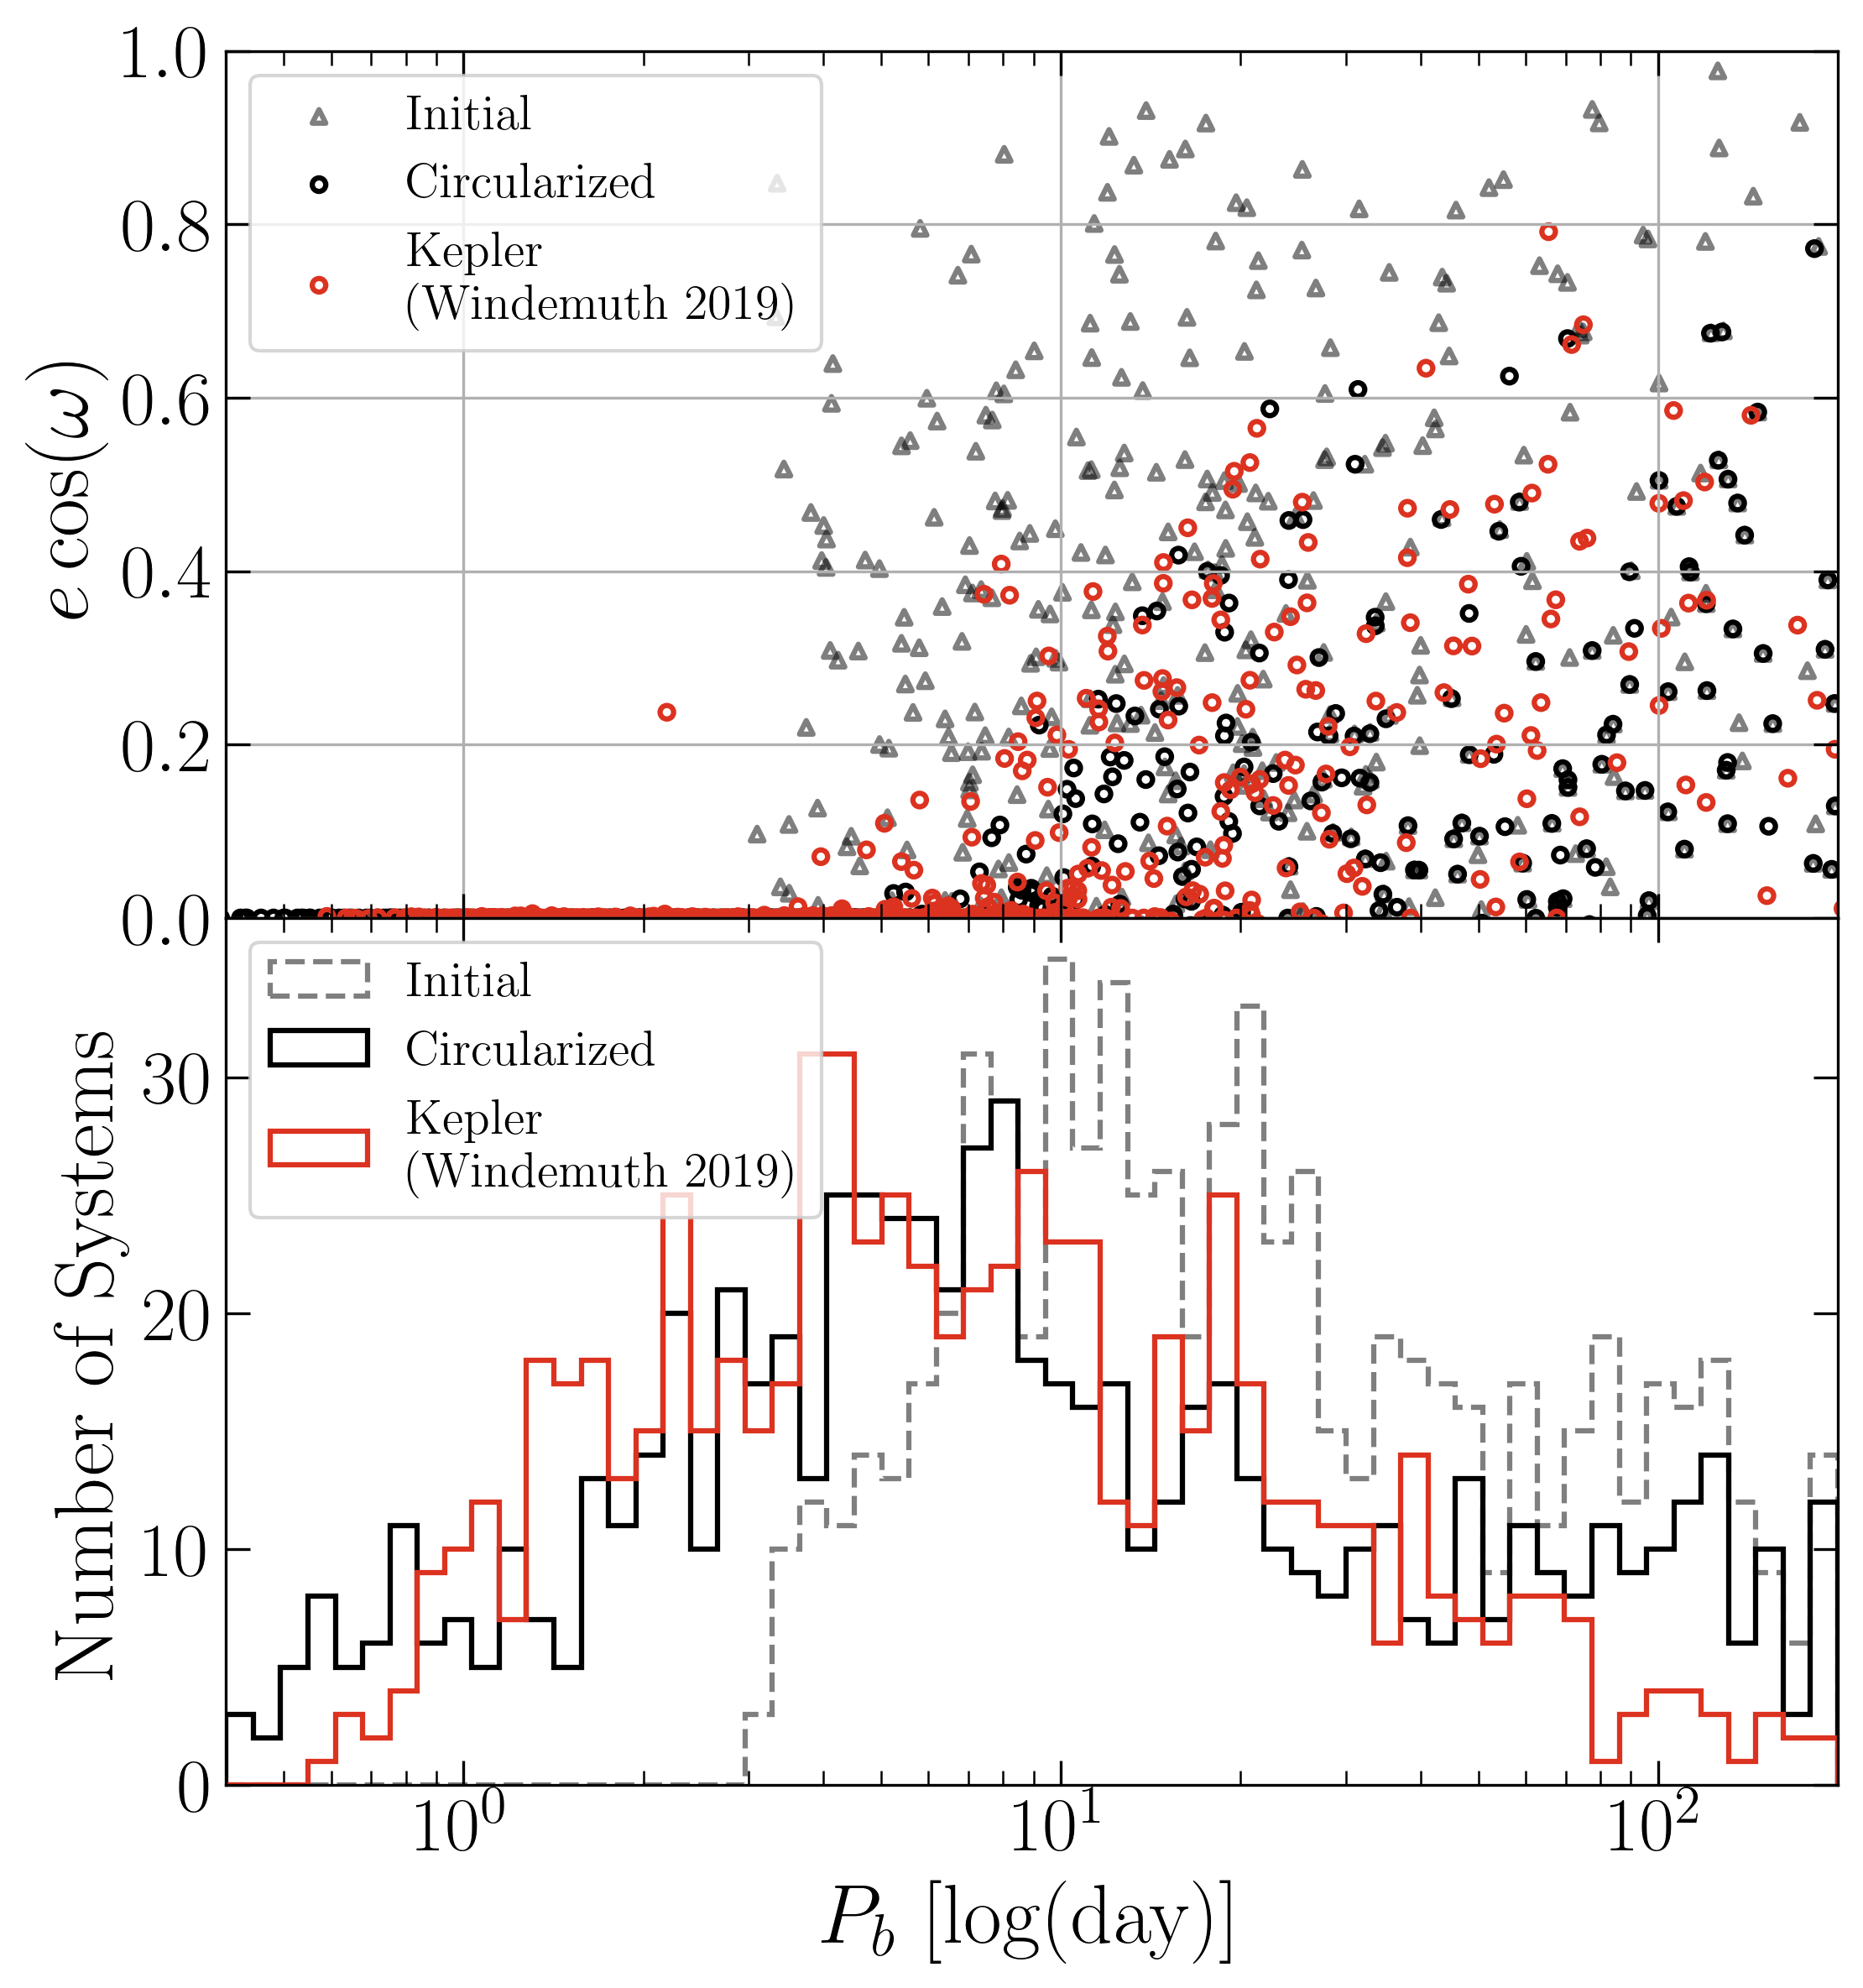

In [100]:
s, lw, fs, density, a = 15, 1.5, 24, False, 0.5
pmin, pmax = 0.4, 200
full_data_ecl = theory[theory['eclipsing?'] & theory['stable?']]
data_ecl = full_data_ecl[:len(windemuth)]

fig = plt.figure(figsize=(7.5, 8), layout='tight')
gs = fig.add_gridspec(2, hspace=0)
axes = gs.subplots(sharex=True)

ecosw = data_ecl['eccentricity']*np.cos(data_ecl['omega'])
axes[0].scatter(data_ecl['period'], ecosw, s=s, edgecolors='k', 
                alpha=a, marker='^', label='Initial', 
                facecolors='none', linewidths=lw)
ecosw = data_ecl['circ_eccentricity']*np.cos(data_ecl['omega'])
axes[0].scatter(data_ecl['circ_period'], ecosw, s=s, linewidths=lw, 
                edgecolors='k', label='Circularized', facecolors='none')
axes[0].scatter(windemuth['P(d)'], windemuth['ecosw'], s=s, 
                edgecolors=color_B, label='Kepler\n(Windemuth 2019)', 
                facecolors='none', linewidths=lw)
axes[0].set_ylim(0, 1)
axes[0].set_ylabel('$e\cos(\omega)$', fontsize=fs)
axes[0].legend(loc=2, fontsize=14)
axes[0].grid(True)

nbins = 60
bins = np.logspace(np.log10(pmin), np.log10(pmax), nbins)
axes[1].hist(data_ecl['period'], bins=bins, histtype='step', 
             color='k', ls='--', density=density, 
             alpha=a, label='Initial', lw=lw)
axes[1].hist(data_ecl['circ_period'], bins=bins, 
             histtype='step', color='k', density=density, 
             label='Circularized', lw=lw)
axes[1].hist(windemuth['P(d)'], bins=bins, histtype='step', 
             density=density, color=color_B, 
             label='Kepler\n(Windemuth 2019)', lw=lw)
axes[1].set_ylabel('Number of Systems', fontsize=fs)
axes[1].legend(loc=2, fontsize=14)

axes[1].set_xlim(pmin, pmax)
axes[1].set_xlabel('$P_{b}$ [log(day)]', fontsize=fs)

for ax in axes:
    ax.tick_params(axis='both', direction='in',
                   which='major', length=7,
                   top=True, bottom=True, 
                   left=True, right=True, 
                   labelsize=fs-2)
    ax.tick_params(axis='both', direction='in',
                   which='minor', length=4,
                   top=True, bottom=True, 
                   left=True, right=True)
plt.xscale('log')
plt.show()

In [24]:
files_control = ('data/e45_d10_a05_m2_0.h5', 
                 'data/e45_d10_a05_m0_0.h5',
                 'data/e45_d10_a05_m1_0.h5')
hist_titles_control = ('No Circularization', 
                       'Planets Form before\nCircularization', 
                       'Planets Form after\nCircularization')

files_eta = ('data/e20_d10_a05_m0_0.h5', 
             'data/e45_d10_a05_m0_0.h5',
             'data/e70_d10_a05_m0_0.h5')
hist_titles_eta = (r'$\eta=2.0$', r'$\eta=4.5$', r'$\eta=7.0$')

files_alpha = ('data/e45_d10_a10_m0_0.h5', 
               'data/e45_d10_a05_m0_0.h5',
               'data/e45_d10_a00_m0_0.h5',
               'data/e45_d10_a-05_m0_0.h5')
hist_titles_alpha = (r'$\alpha=1.0$', r'$\alpha=0.5$', 
                     r'$\alpha=0.0$', r'$\alpha=-0.5$')

files_sigma = ('data/e45_d03_a05_m0_0.h5', 
              'data/e45_d10_a05_m0_0.h5',
              'data/e45_d30_a05_m0_0.h5')
hist_titles_sigma = (r'$\sigma (i_m)=0.3$', r'$\sigma (i_m)=1.0$', 
                     r'$\sigma (i_m)=3.0$')

all_dfs = [[df[df.Transit_Value == 2] 
        for df in [read_df(file) for file in files]] 
        for files in [files_eta, files_sigma, files_alpha]]
all_hist_titles = (hist_titles_eta, hist_titles_sigma, hist_titles_alpha)

observations = {'Kepler 16b' : {'M_A': 0.69,"M_B": 0.2,'a_b': 0.22,
                                'a_p': 0.7,'e_b': 0.16, 'outlier': 0},
                'Kepler 34b' : {'M_A': 1.05,"M_B": 1.02,'a_b': 0.23,
                                'a_p': 1.09,'e_b': 0.52, 'outlier': 0},
                'Kepler 35b' : {'M_A': 0.89,"M_B": 0.81,'a_b': 0.18,
                                'a_p': 0.6,'e_b': 0.14, 'outlier': 0},
                'Kepler 38b' : {'M_A': 0.95,"M_B": 0.25,'a_b': 0.15,
                                'a_p': 0.46,'e_b': 0.1, 'outlier': 0},
                'Kepler 47b' : {'M_A': 1.04,"M_B": 0.36,'a_b': 0.084,
                                'a_p': 0.3,'e_b': 0.023, 'outlier': 0},
                'Kepler 47c' : {'M_A': 1.04,"M_B": 0.36,'a_b': 0.084,
                                'a_p': 0.99,'e_b': 0.023, 'outlier': 1}, 
                'Kepler 47d' : {'M_A': 1.04,"M_B": 0.36,'a_b': 0.084,
                                'a_p': 	0.699,'e_b': 0.023, 'outlier': 1},
                'Kepler 64b' : {'M_A': 1.53,"M_B": 0.41,'a_b': 0.17,
                                'a_p': 0.63,'e_b': 0.21, 'outlier': 0},
                'Kepler 413b' : {'M_A': 0.82,"M_B": 0.54,'a_b': 0.1,
                                 'a_p': 0.36,'e_b': 0.037, 'outlier': 0},
                'Kepler 453b' : {'M_A': 0.93,"M_B": 0.19,'a_b': 0.18,
                                 'a_p': 0.79,'e_b': 0.051, 'outlier': 0},
                'Kepler 1647b' : {'M_A': 1.22,"M_B": 0.97,'a_b': 0.13,
                                  'a_p': 2.72,'e_b': 0.16, 'outlier': 2},
                'Kepler 1661b' : {'M_A': 0.84,"M_B": 0.26,'a_b': 0.187,
                                  'a_p': 0.633,'e_b': 0.112, 'outlier': 0},
                'TOI 1338' : {'M_A': 1.127,"M_B": 0.3128,'a_b': 0.1321,
                              'a_p': 0.4491,'e_b': 0.156, 'outlier': 0}
                }

observations_df = pd.DataFrame({'name': observations.keys()})
for key in observations['Kepler 16b']:
    observations_df[key] = [observations[i][key] for i in observations]

for name, info in observations.items():
    info['P_b'] = a2p(info['a_b'], info['M_A'])
    info['P_p'] = a2p(info['a_p'], info['M_A']+info['M_B'])

obs_P_b = [info['P_b'] for _, info in observations.items()]
obs_P_p = [info['P_p'] for _, info in observations.items()]

from astropy import table, io
df = observations_df.copy().drop(columns=['outlier'])
tbl = table.Table.from_pandas(df)
io.ascii.write(tbl, format='latex')

\begin{table}
\begin{tabular}{cccccc}
name & M_A & M_B & a_b & a_p & e_b \\
Kepler 16b & 0.69 & 0.2 & 0.22 & 0.7 & 0.16 \\
Kepler 34b & 1.05 & 1.02 & 0.23 & 1.09 & 0.52 \\
Kepler 35b & 0.89 & 0.81 & 0.18 & 0.6 & 0.14 \\
Kepler 38b & 0.95 & 0.25 & 0.15 & 0.46 & 0.1 \\
Kepler 47b & 1.04 & 0.36 & 0.084 & 0.3 & 0.023 \\
Kepler 47c & 1.04 & 0.36 & 0.084 & 0.99 & 0.023 \\
Kepler 47d & 1.04 & 0.36 & 0.084 & 0.699 & 0.023 \\
Kepler 64b & 1.53 & 0.41 & 0.17 & 0.63 & 0.21 \\
Kepler 413b & 0.82 & 0.54 & 0.1 & 0.36 & 0.037 \\
Kepler 453b & 0.93 & 0.19 & 0.18 & 0.79 & 0.051 \\
Kepler 1647b & 1.22 & 0.97 & 0.13 & 2.72 & 0.16 \\
Kepler 1661b & 0.84 & 0.26 & 0.187 & 0.633 & 0.112 \\
TOI 1338 & 1.127 & 0.3128 & 0.1321 & 0.4491 & 0.156 \\
\end{tabular}
\end{table}


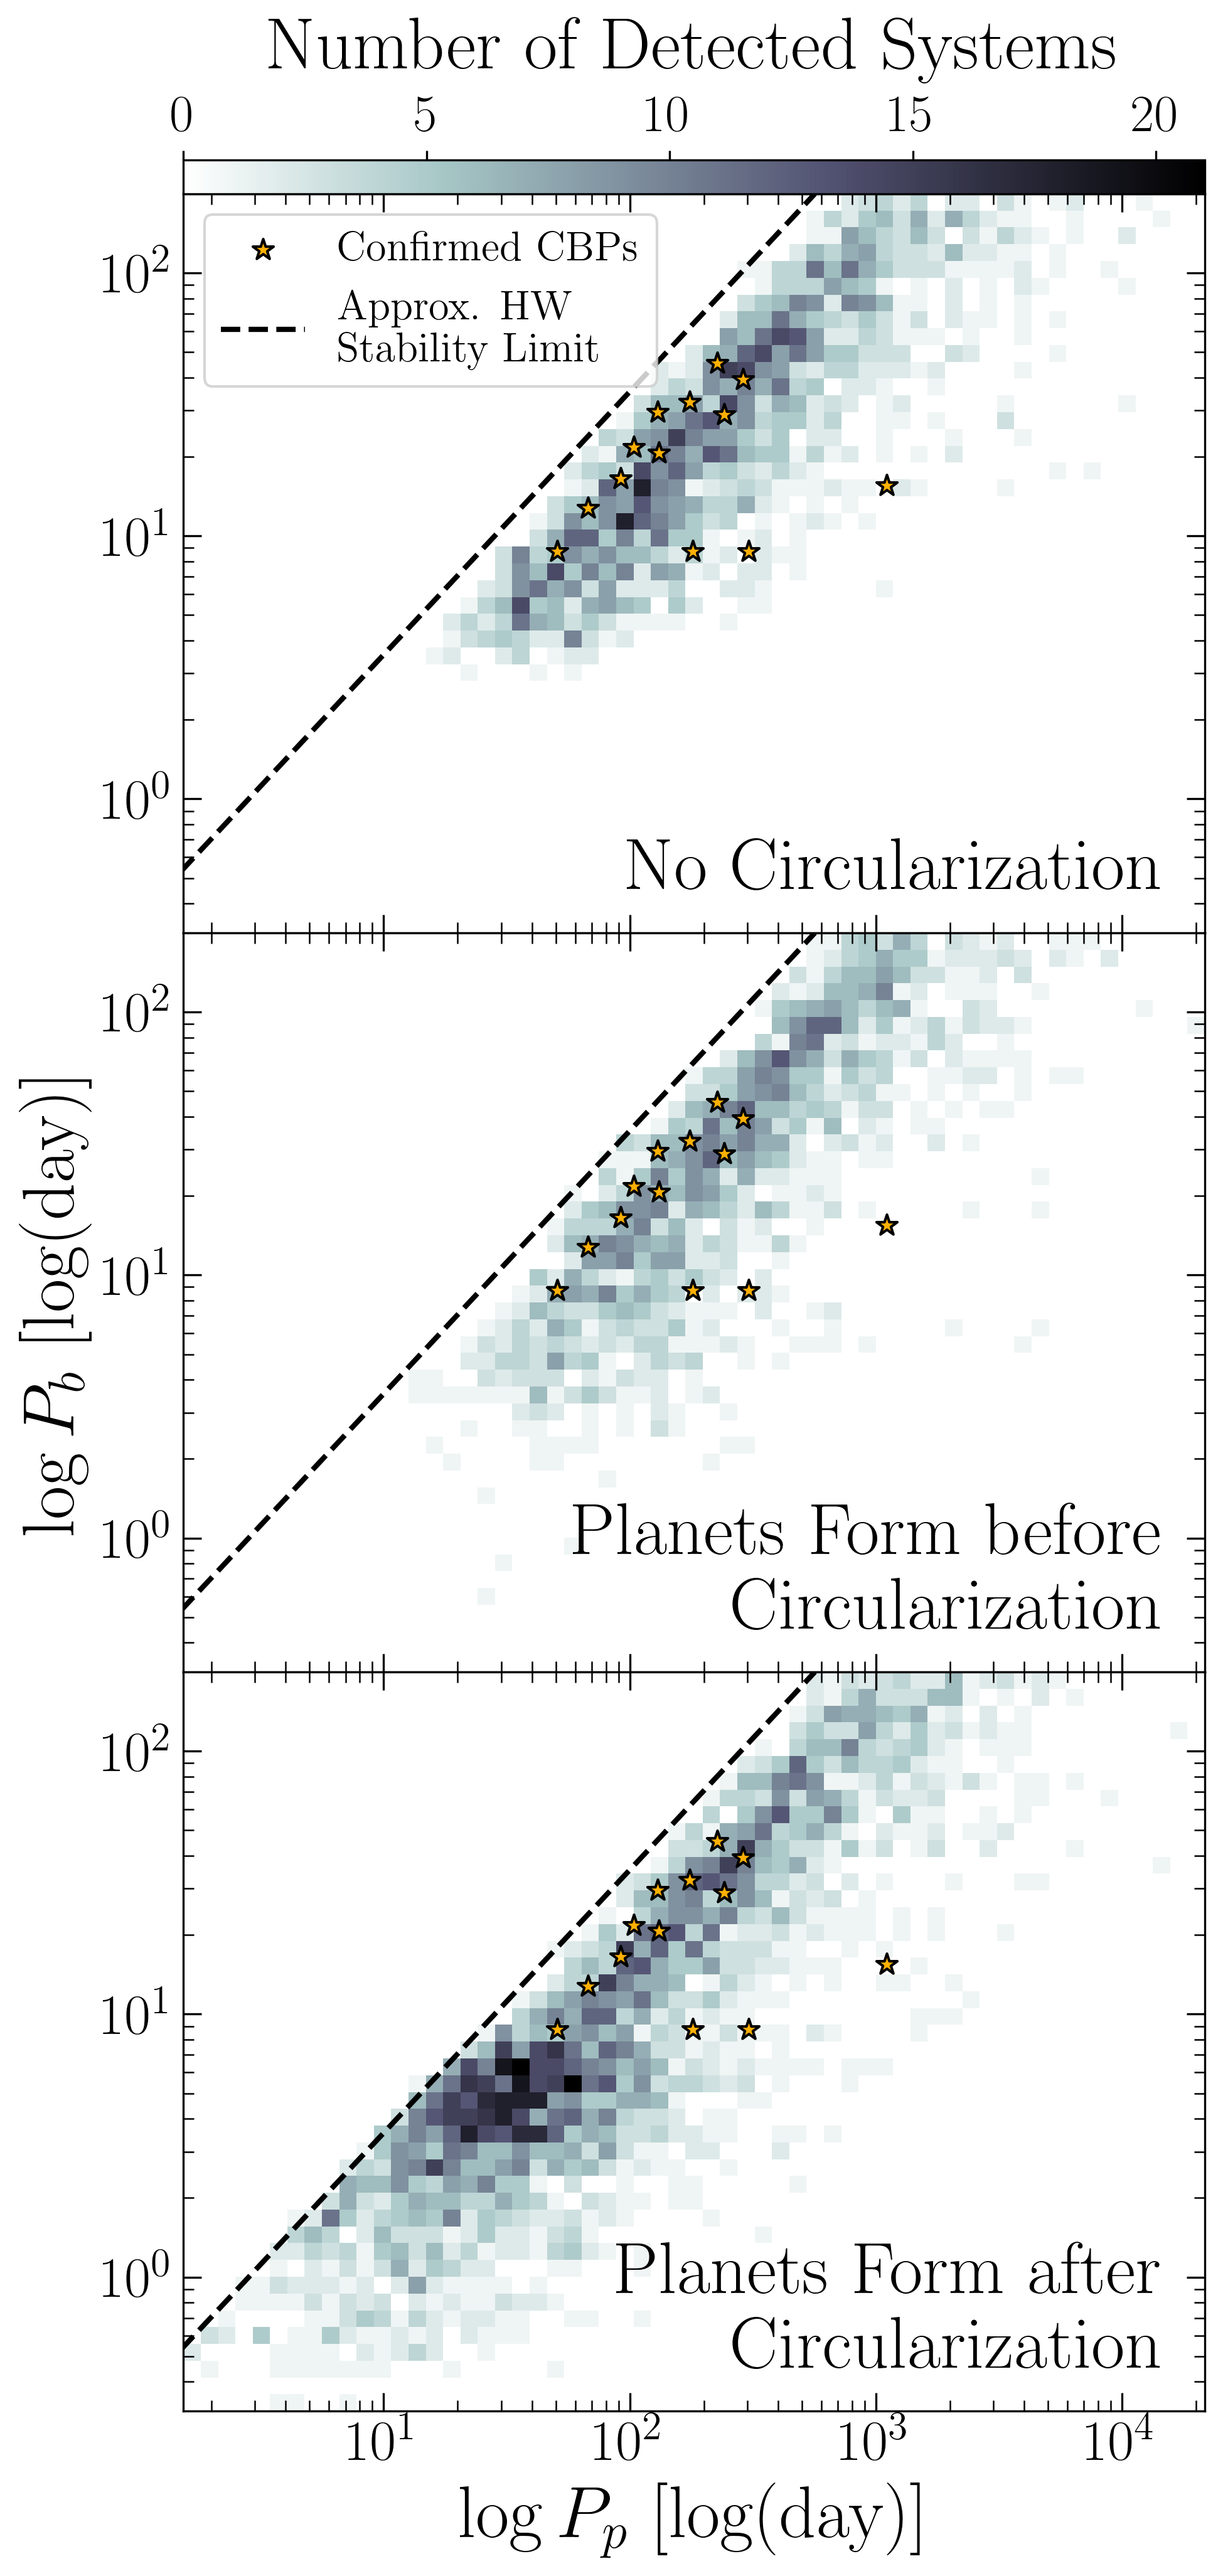

In [19]:
files = files_control
hist_titles = hist_titles_control
fractional = False

fs = 28

dfs = [df[df.Transit_Value == 2] for df in [read_df(file) for file in files]]

nbinsx = 60
nbinsy = 45
pbmin = ppmin = 200
pbmax = ppmax = 0
for df in dfs:
      p, b = df.Planet_Period, df.Binary_Period
      pbmin = min(np.amin(b), pbmin)
      pbmax = max(np.amax(b), pbmax)
      ppmin = min(np.amin(p), ppmin)
      ppmax = max(np.amax(p), ppmax)
bins = (np.logspace(np.log10(ppmin), np.log10(ppmax), nbinsx), 
        np.logspace(np.log10(pbmin), np.log10(pbmax), nbinsy))

vmax = 0
for df in dfs:
      hist = np.histogram2d(df.Planet_Period, df.Binary_Period, bins=bins)
      if fractional: tmp = 100*hist[0].max() / len(df)
      else: tmp = hist[0].max()
      vmax = max(vmax, tmp)
norm = plt.cm.colors.Normalize(vmin=0, vmax=vmax)
cmap = plt.cm.get_cmap('bone_r')
sc = plt.cm.ScalarMappable(norm=norm, cmap=cmap)

fig = plt.figure(figsize=(7, 18)) #21
gs = fig.add_gridspec(len(files), hspace=0)
axes = gs.subplots(sharex=True, sharey=True)

x = np.linspace(pbmin, pbmax, 100)
for i, (df, ax) in enumerate(zip(dfs, axes)):
       if fractional:
              weights = np.full_like(df.Planet_Period.values, 100/len(df), dtype=float)
       else:
             weights = np.ones_like(df.Planet_Period.values, dtype=float)
       hist, _, _, _ = ax.hist2d(df.Planet_Period, df.Binary_Period, 
                                 bins=bins, cmap=cmap, norm=norm, weights=weights)
       ax.scatter(obs_P_p, obs_P_b, label='Confirmed CBPs', marker='*', s=70, 
                  facecolors=color_C, edgecolors='k', linewidths=1)
       ax.plot(2**1.5*x, x, 'k--', label='Approx. HW\nStability Limit', lw=2)

       ax.set_xscale('log')
       ax.set_yscale('log')
       ax.tick_params(axis='both', direction='in', top=True, bottom=True, 
                      right=True, left=True, labelsize=fs-6, which='major', 
                      length=7)
       ax.tick_params(axis='both', direction='in', top=True, bottom=True, 
                      right=True, left=True, labelsize=fs-6, which='minor',
                      length=4)

       if fractional:
            h = 9e-1 if i == 0 else 17e-1
            ax.text(1.5e4, h, f'{len(df)} Systems', fontsize=fs, ha='right')
       ax.text(1.5e4, 4.5e-1, hist_titles[i], fontsize=fs, ha='right')

       if i == 0: ax.legend(fontsize=16, loc='upper left')
       if i == 1 and not fractional: 
             ax.set_ylabel('$\log P_{b}$ [log(day)]', fontsize=fs)
       if i == 2: ax.set_xlabel('$\log P_{p}$ [log(day)]', fontsize=fs)

if fractional: 
      fig.supylabel('$\log P_{b}$ [log(day)]', fontsize=fs)
cbar = fig.colorbar(sc, ax=axes, aspect=30, orientation='horizontal', 
                    location='top', pad=0)
cbar.set_label(label='Number of Detected Systems', fontsize=fs, labelpad=10)
cbar.ax.tick_params(axis='x', labelsize=fs-8, bottom=False, top=True, 
                    labeltop=True, labelbottom=False)
plt.show()

# increase fontsize of labels, text and make ticks bigger

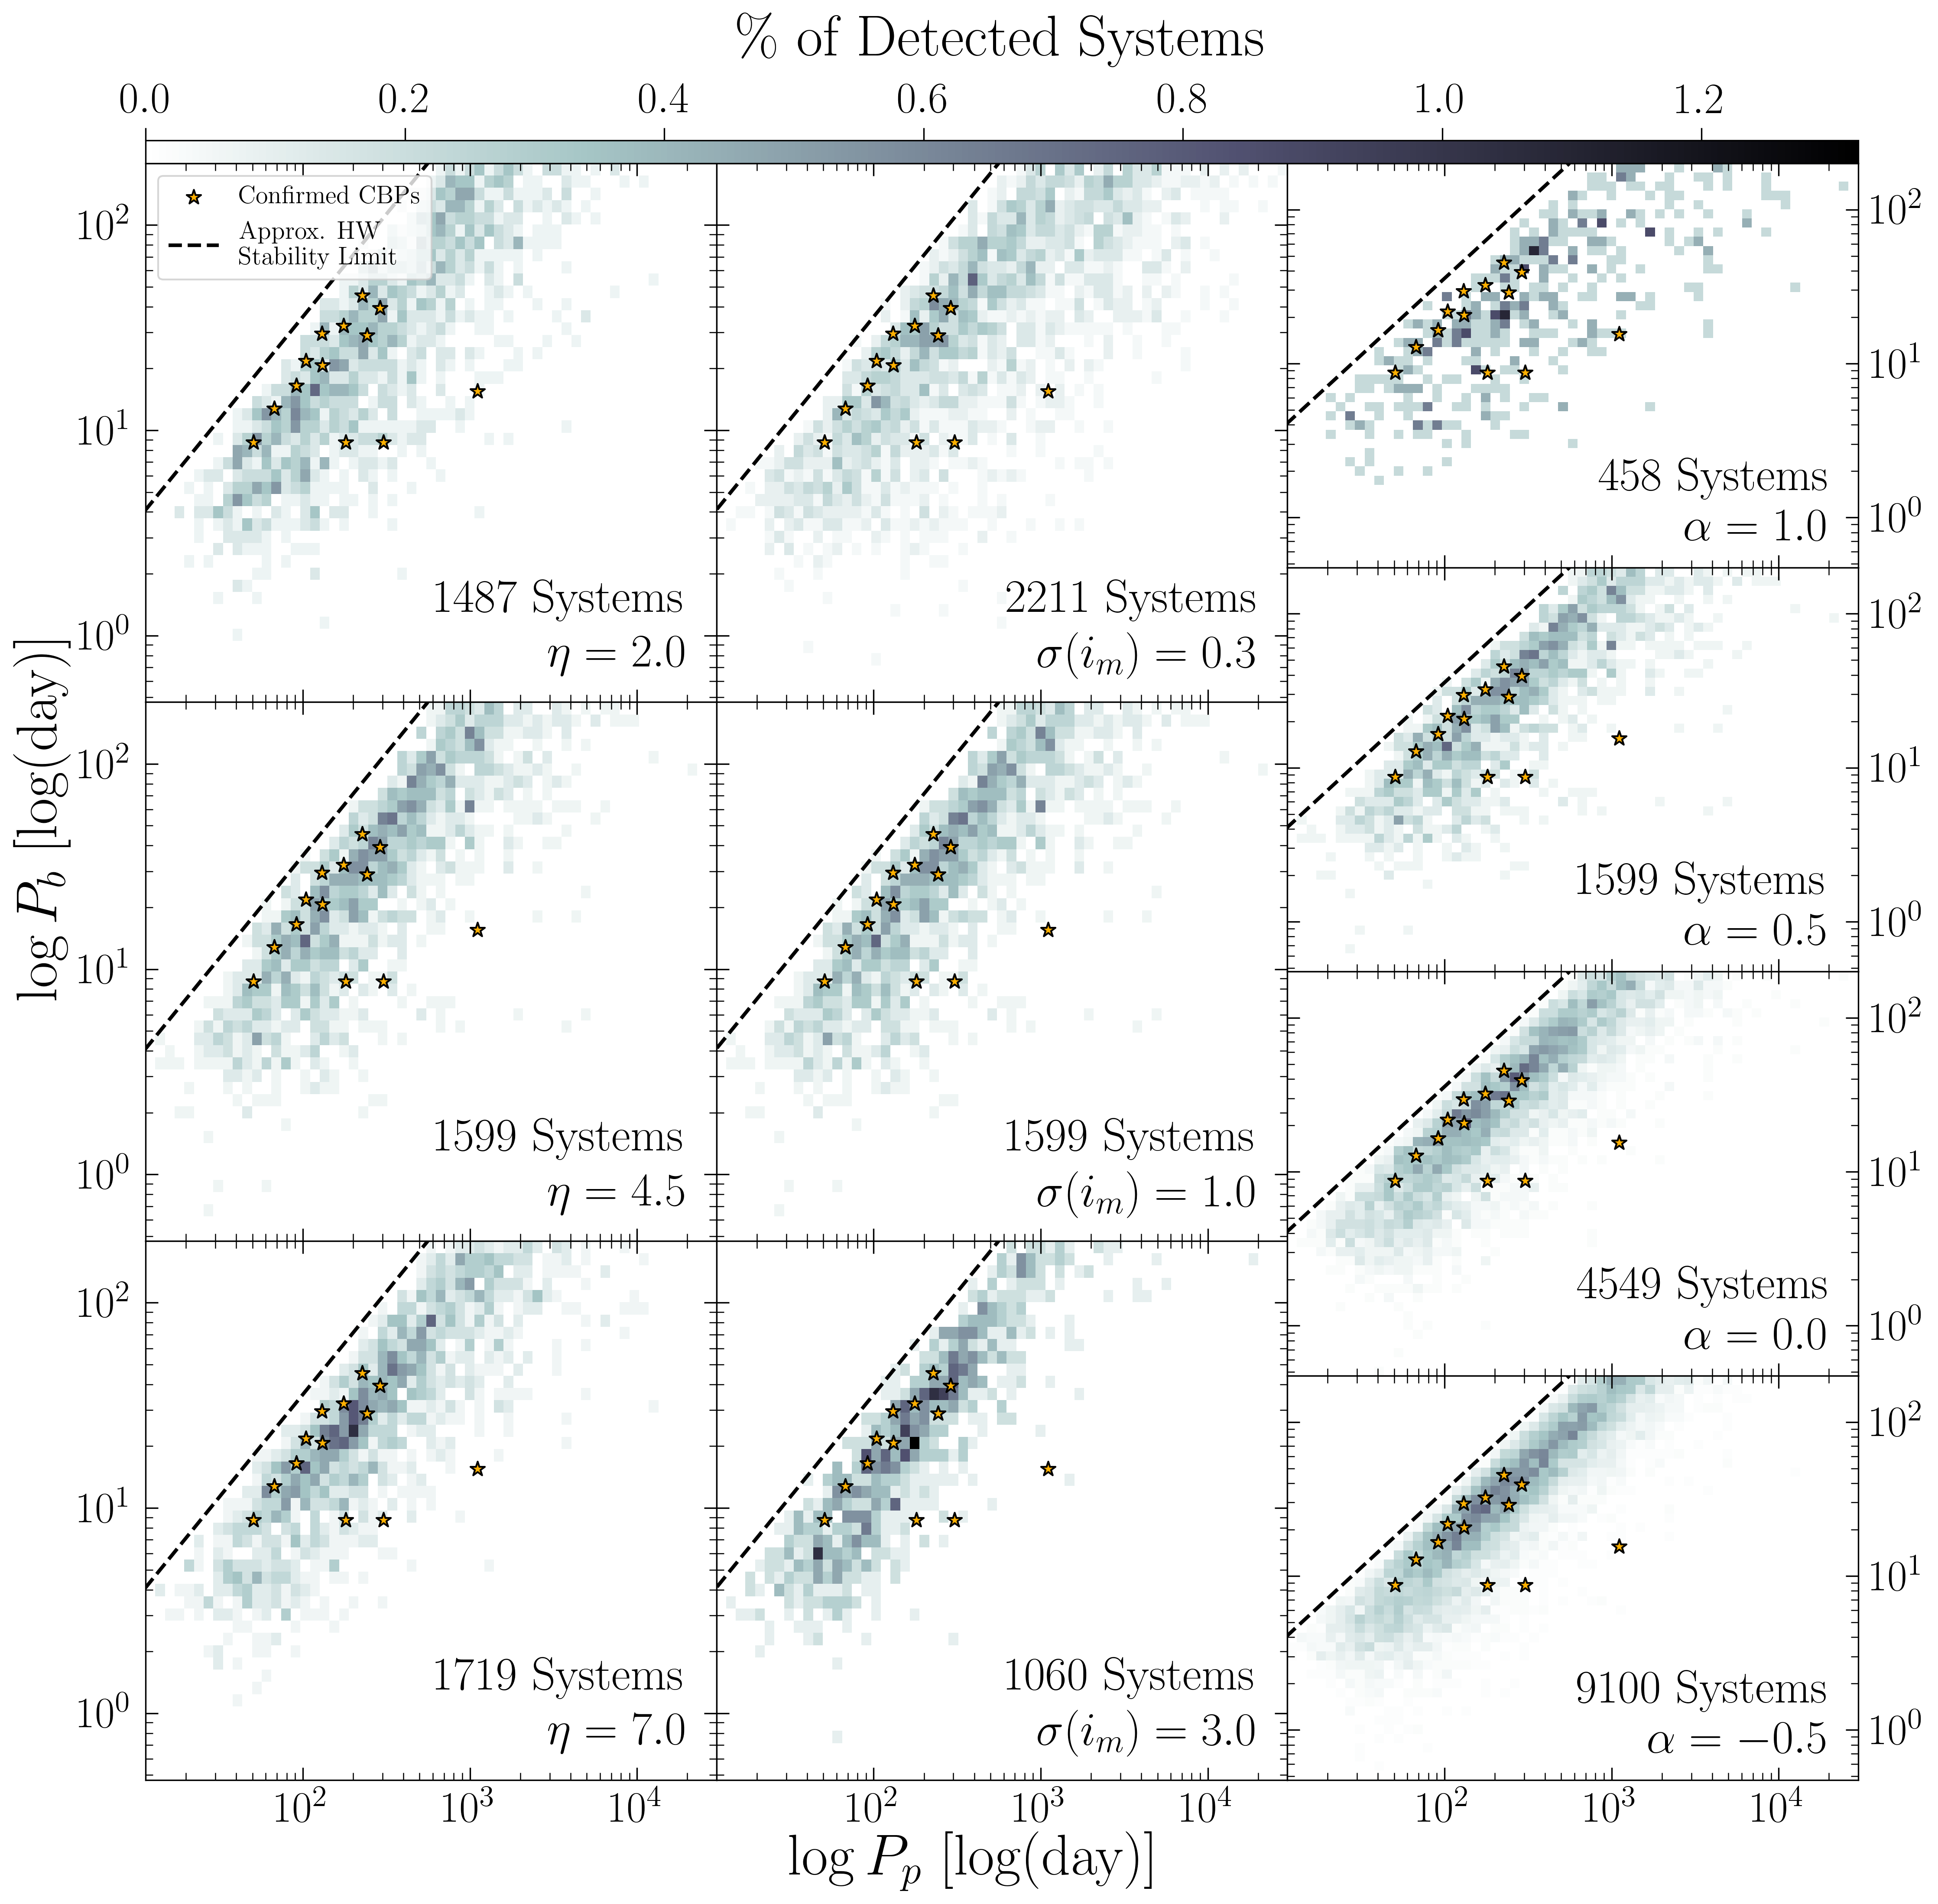

In [32]:
fs = 32
nrows = 3*4
ncols = 3
fig, axs = plt.subplots(ncols=ncols, nrows=nrows, figsize=(17, 19),
                        sharex=True, sharey=True)
gs = axs[0, 0].get_gridspec()
gs.update(hspace=0, wspace=0)
dfs = all_dfs
dfs_flat = [x for xs in dfs for x in xs]

nbinsx = 60
nbinsy = 45
pbmin = ppmin = 200
pbmax = ppmax = 0

for df in dfs_flat:
    p, b = df.Planet_Period, df.Binary_Period
    pbmin = min(np.amin(b), pbmin)
    pbmax = max(np.amax(b), pbmax)
    ppmin = min(np.amin(p), ppmin)
    ppmax = max(np.amax(p), ppmax)
bins = (np.logspace(np.log10(ppmin), np.log10(ppmax), nbinsx), 
        np.logspace(np.log10(pbmin), np.log10(pbmax), nbinsy))

vmax = 0
for df in dfs_flat:
    hist = np.histogram2d(df.Planet_Period, df.Binary_Period, bins=bins)
    tmp = 100*hist[0].max() / len(df)
    vmax = max(vmax, tmp)
norm = plt.cm.colors.Normalize(vmin=0, vmax=vmax)
cmap = plt.cm.get_cmap('bone_r')
sc = plt.cm.ScalarMappable(norm=norm, cmap=cmap)
x = np.linspace(pbmin, pbmax, 100)

for ncol in range(ncols):
    start = 0
    step = 3 if ncol == 2 else 4
    j = ncol
    for nrow in range(nrows):
        end = start+step
        slc, col = slice(start, end), ncol
        if start % step: 
            start += 1
            continue
        for _ax in axs[slc, col]: 
            _ax.remove()
        ax = fig.add_subplot(gs[slc, col])
        i = nrow // step
        df = dfs[j][i]
        ax.tick_params(axis='both', direction='in', top=True, bottom=True, 
                       right=True, left=True, labelsize=fs-8, which='major', 
                       length=7, labelleft=(j==0), labelright=(j==2), pad=7)
        ax.tick_params(axis='both', direction='in', top=True, bottom=True, 
                       right=True, left=True, which='minor', length=4)
        weights = np.full_like(df.Planet_Period.values, 
                               100/len(df), dtype=float)
        hist, _, _, _ = ax.hist2d(df.Planet_Period, df.Binary_Period, 
                                  bins=bins, cmap=cmap, 
                                  norm=norm, weights=weights)
        ax.scatter(obs_P_p, obs_P_b, label='Confirmed CBPs', marker='*', 
                   s=70, facecolors=color_C, edgecolors='k', linewidths=1)
        ax.plot(2.8*x, x, 'k--', lw=2, 
                label='Approx. HW\nStability Limit')
        ax.set_xscale('log')
        ax.set_yscale('log')
        h = 15e-1 if j == 2 else 13e-1
        # txt = fr'$\textbf{{{len(df)} Systems}}$' if i == 1 else 
        txt = f'{len(df)} Systems'
        ax.text(2e4, h, txt, fontsize=fs-6, ha='right')
        ax.text(2e4, 7e-1, all_hist_titles[j][i], fontsize=fs-6, ha='right')
        if not i and not j:
            ax.legend(fontsize=14, loc='upper left')
        start += 1
fig.supylabel('$\log P_{b}$ [log(day)]', fontsize=fs, x=0.065)
fig.supxlabel('$\log P_{p}$ [log(day)]', fontsize=fs, y=0.065)
cbar = fig.colorbar(sc, ax=fig.axes, aspect=75, 
                    orientation='horizontal', 
                    location='top', pad=0)
cbar.set_label(label='\% of Detected Systems', fontsize=fs, labelpad=15)
cbar.ax.tick_params(axis='x', labelsize=fs-8, 
                    bottom=False, top=True, length=7,
                    labeltop=True, labelbottom=False)
plt.show()

In [13]:
# try alpha = -0.5
# check eccentricities of observed planets
# check out planet periods
#       - mb units or p2a function (step through)
# edge of the multis READ sarah millholland

In [204]:
lw = 1
files = files_control
hist_titles = hist_titles_control
fig, axes = plt.subplots(len(files), 1, sharex=True, sharey=True,
                         layout='constrained', figsize=(7, 12))

for ax, file, title in zip(axes, files, hist_titles):
        df = read_df(file)
        df = df[df.Transit_Value == 2]
        df = df.fillna(value=np.nan)
        R = df.Radius_A + df.Radius_B
        a = df.Binary_Semimajor_Axis
        e = df.Binary_Eccentricity
        i = np.rad2deg(df.Binary_Inclination)-90
        p = df.Binary_Period

        omega = np.deg2rad(df.Binary_omega)
        ecosw = e * np.cos(omega)
        corr = (1-np.abs(ecosw))/(1-e**2)
 
        eb = abs(np.sin(np.deg2rad(i))) <= R/a * corr
        ax.hist(df.Binary_Period[eb], bins=bins[1], histtype='step', lw=lw, 
                color='#a12033', label='Eclipsing Binaries')
        ax.hist(df.Binary_Period[~eb], bins=bins[1], histtype='step', lw=lw, 
                color='#2c20ab', label='Non-Eclipsing Binaries')
        ax.set_xscale('log')
        ax.set_xlim(pbmin, pbmax)
        ax.tick_params(labelsize=fs)
        ax.set_title(title, fontsize=fs)
        ax.legend(fontsize=0.75*fs, loc='upper left')

fig.supylabel('Number of Systems', fontsize=fs)
fig.supxlabel('$\log P_{b}$ [log(day)]', fontsize=fs)
fig.suptitle('Distributions of Eclipsing and Non-Eclipsing Binaries', 
             fontsize=fs)
plt.close()

In [76]:
all_systems = observations_df.copy()
p_ratio_obs = []
for i, planet in all_systems.iterrows():
    mu = planet['M_B']/(planet['M_B']+planet['M_B'])
    a_HW = HW99(mu, planet['e_b'], planet['a_b'])
    P_HW = a2p(a_HW, planet['M_A']+planet['M_B'])
    P_p = a2p(planet['a_p'], planet['M_A']+planet['M_B'])
    p_ratio_obs = np.append(p_ratio_obs, P_p/P_HW)
p_ratio_obs_all = np.sort(p_ratio_obs)

no_outlier_systems = observations_df[observations_df['outlier'] == 0]
p_ratio_obs = []
for i, planet in no_outlier_systems.iterrows():
    mu = planet['M_B']/(planet['M_B']+planet['M_B'])
    a_HW = HW99(mu, planet['e_b'], planet['a_b'])
    P_HW = a2p(a_HW, planet['M_A']+planet['M_B'])
    P_p = a2p(planet['a_p'], planet['M_A']+planet['M_B'])
    p_ratio_obs = np.append(p_ratio_obs, P_p/P_HW)
p_ratio_obs_no_outliers = np.sort(p_ratio_obs)

nbins = 1_000
files = files_control
hist_titles = hist_titles_control
p = [[], []]

for file, title in zip(files, hist_titles):
    # print(title)
    df = read_df(file)
    df = df[df.Transit_Value == 2]
    mu = df.Mass_B/(df.Mass_A+df.Mass_B)
    a_HW = HW99(mu, df.Binary_Eccentricity, df.Binary_Semimajor_Axis)
    P_HW = np.array([a2p(a, df.Mass_A.iloc[i]+df.Mass_B.iloc[i]) 
                    for i, a in enumerate(a_HW)])

    p_ratio = df.Planet_Period/P_HW
    count, bins_count = np.histogram(p_ratio, bins=nbins) 
    cdf = np.concatenate(([0], np.cumsum(count)/(np.sum(count)-1)))

    _, p_KS_all = ks_2samp(p_ratio_obs_all, p_ratio)
    # print('all:', p_KS_all)
    p[0].append(round(p_KS_all, 4))

    _, p_KS_no_outliers = ks_2samp(p_ratio_obs_no_outliers, p_ratio)
    # print('no outliers:', p_KS_no_outliers)
    p[1].append(round(p_KS_no_outliers, 4))
    # print()

In [79]:
p_titles = [' ', r'$p_{\rm all}$', r'$p_{\rm in}$']
h_titles = np.reshape(hist_titles_control, (3, 1))
dat = np.hstack((h_titles, np.transpose(p)))
df = pd.DataFrame(dat, columns=p_titles)
tbl = table.Table.from_pandas(df)
io.ascii.write(tbl, format='latex')

\begin{table}
\begin{tabular}{ccc}
 & $p_{\rm all}$ & $p_{\rm in}$ \\
No Circularization & 0.6287 & 0.0549 \\
Planets Form before
Circularization & 0.2499 & 0.0128 \\
Planets Form after
Circularization & 0.1135 & 0.0042 \\
\end{tabular}
\end{table}


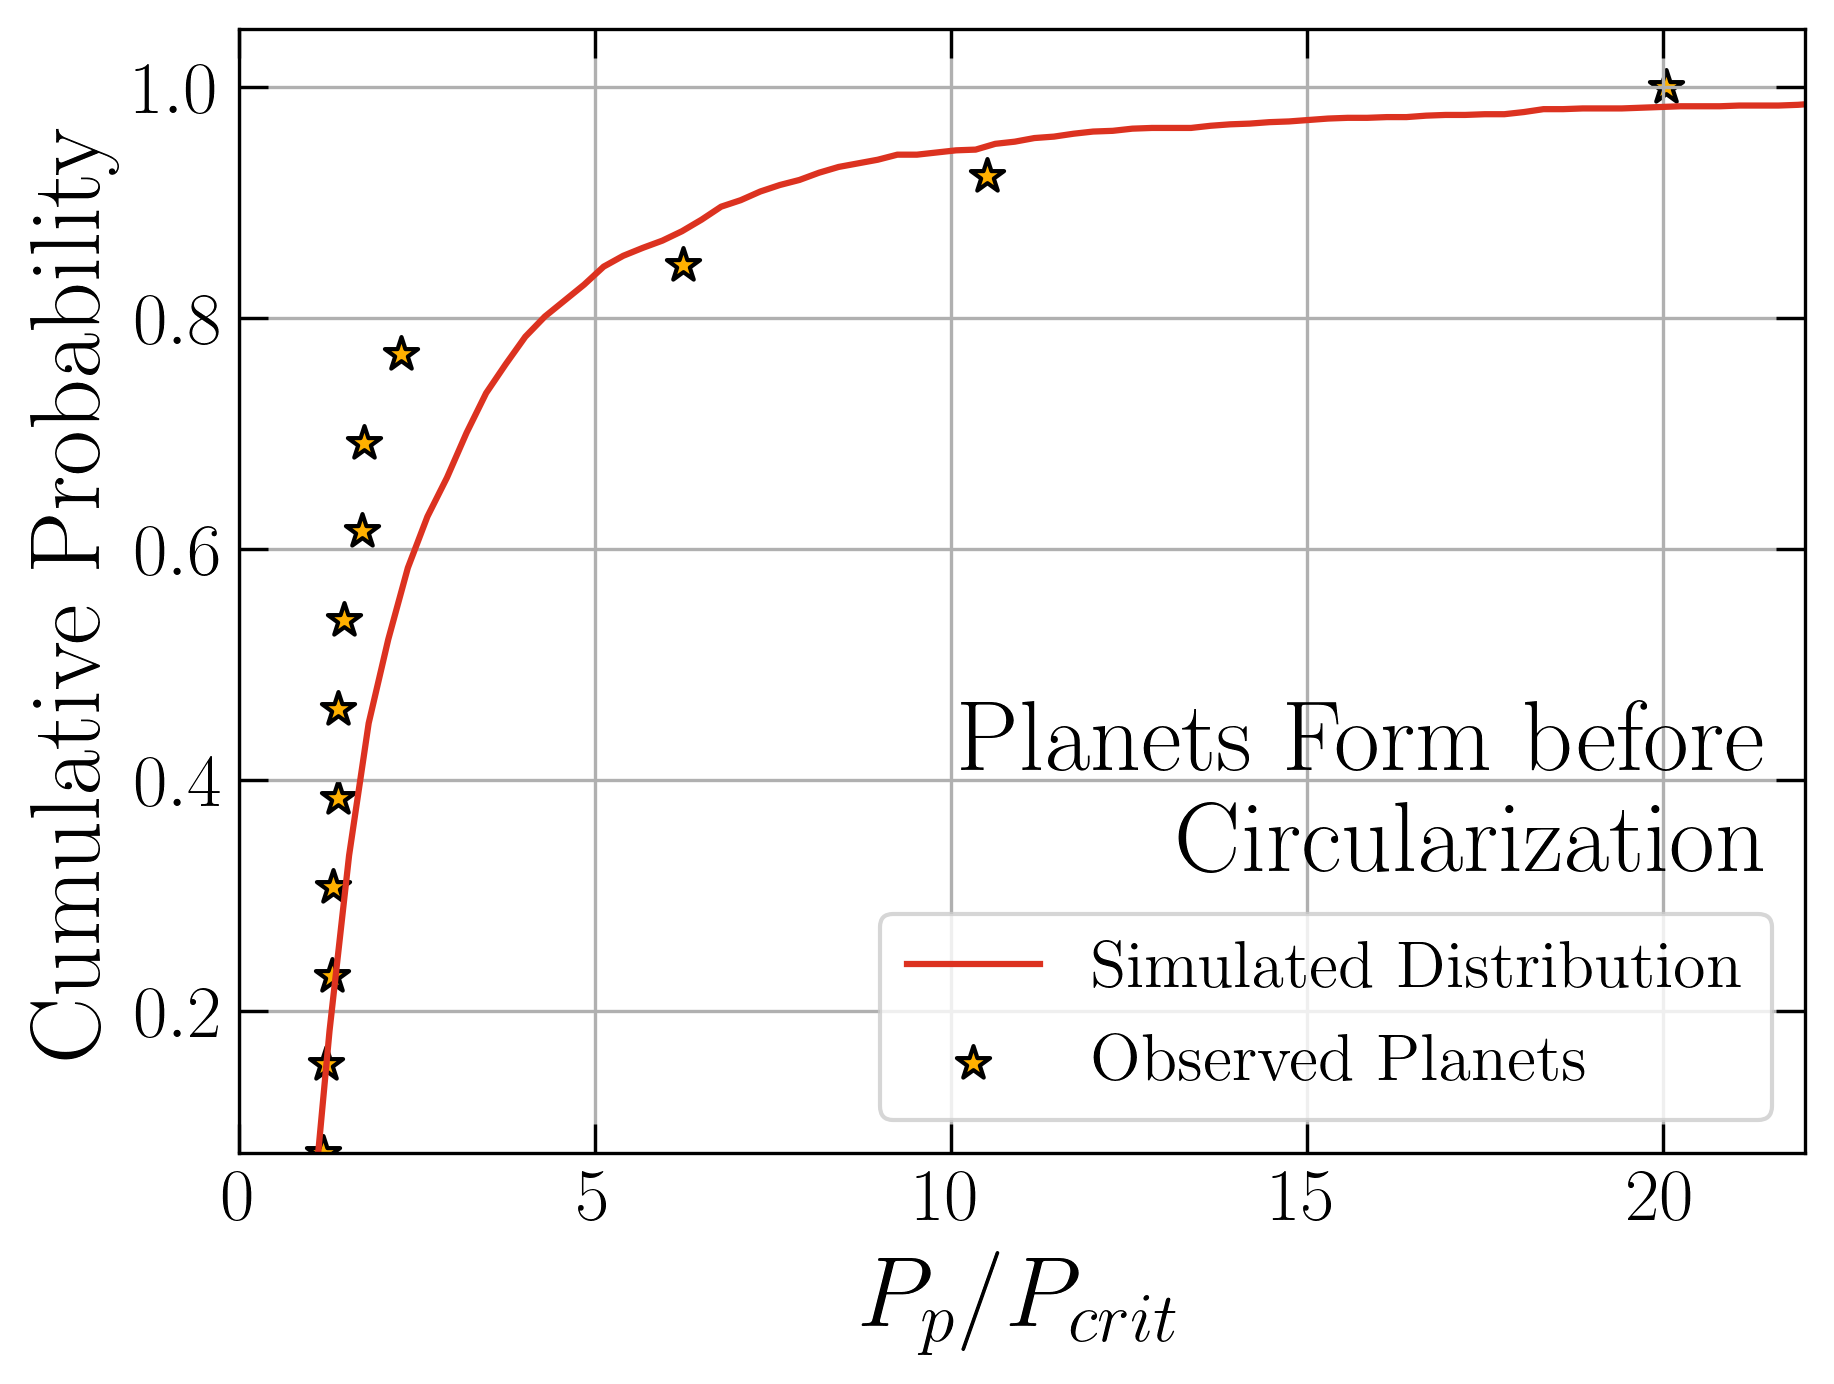

In [116]:
p_ratio_obs = []
for planet in observations:
    planet_data = observations[planet]
    mu = planet_data['M_B']/(planet_data['M_B']+planet_data['M_B'])
    a_HW = HW99(mu, planet_data['e_b'], planet_data['a_b'])
    P_HW = a2p(a_HW, planet_data['M_A']+planet_data['M_B'])
    P_p = a2p(planet_data['a_p'], planet_data['M_A']+planet_data['M_B'])
    p_ratio_obs = np.append(p_ratio_obs, P_p/P_HW)
p_ratio_obs_all = np.sort(p_ratio_obs)
rvs_all = (np.arange(p_ratio_obs.size)+1)/p_ratio_obs.size

fs = 24
nbins = 1_000
files = files_control[1:-1]
hist_titles = hist_titles_control[1:-1]
fig, axes = plt.subplots(1, 1, sharex=True, sharey=True, squeeze=False,
                         layout='constrained', figsize=(6, 4.5))

for ax, file, title in zip(axes[0], files, hist_titles):
    df = read_df(file)
    df = df[df.Transit_Value == 2]
    mu = df.Mass_B/(df.Mass_A+df.Mass_B)
    a_HW = HW99(mu, df.Binary_Eccentricity, df.Binary_Semimajor_Axis)
    P_HW = np.array([a2p(a, df.Mass_A.iloc[i]+df.Mass_B.iloc[i]) 
                    for i, a in enumerate(a_HW)])

    p_ratio = df.Planet_Period/P_HW
    count, bins_count = np.histogram(p_ratio, bins=nbins) 
    cdf = np.concatenate(([0], np.cumsum(count)/(np.sum(count)-1)))
    ax.plot(bins_count, cdf, c=color_B, label='Simulated Distribution')

    ax.scatter(p_ratio_obs_all, rvs_all, label='Observed Planets', 
               marker='*', s=70, facecolors=color_C, 
               edgecolors='k', linewidths=1)
    ax.set_xlim(0, 22)
    ax.set_ylim(rvs_all.min(), None)
    ax.text(21.5, 0.32, title, fontsize=fs, ha='right')
    ax.legend(fontsize=16)
    ax.tick_params(axis='both', direction='in', 
                   top=True, bottom=True, 
                   left=True, right=True, 
                   labelsize=fs-6, which='both', 
                   length=7)
    ax.set_xlabel('$P_p/P_{crit}$', fontsize=fs)
    ax.set_ylabel('Cumulative Probability', fontsize=fs)
    ax.grid()
plt.show()

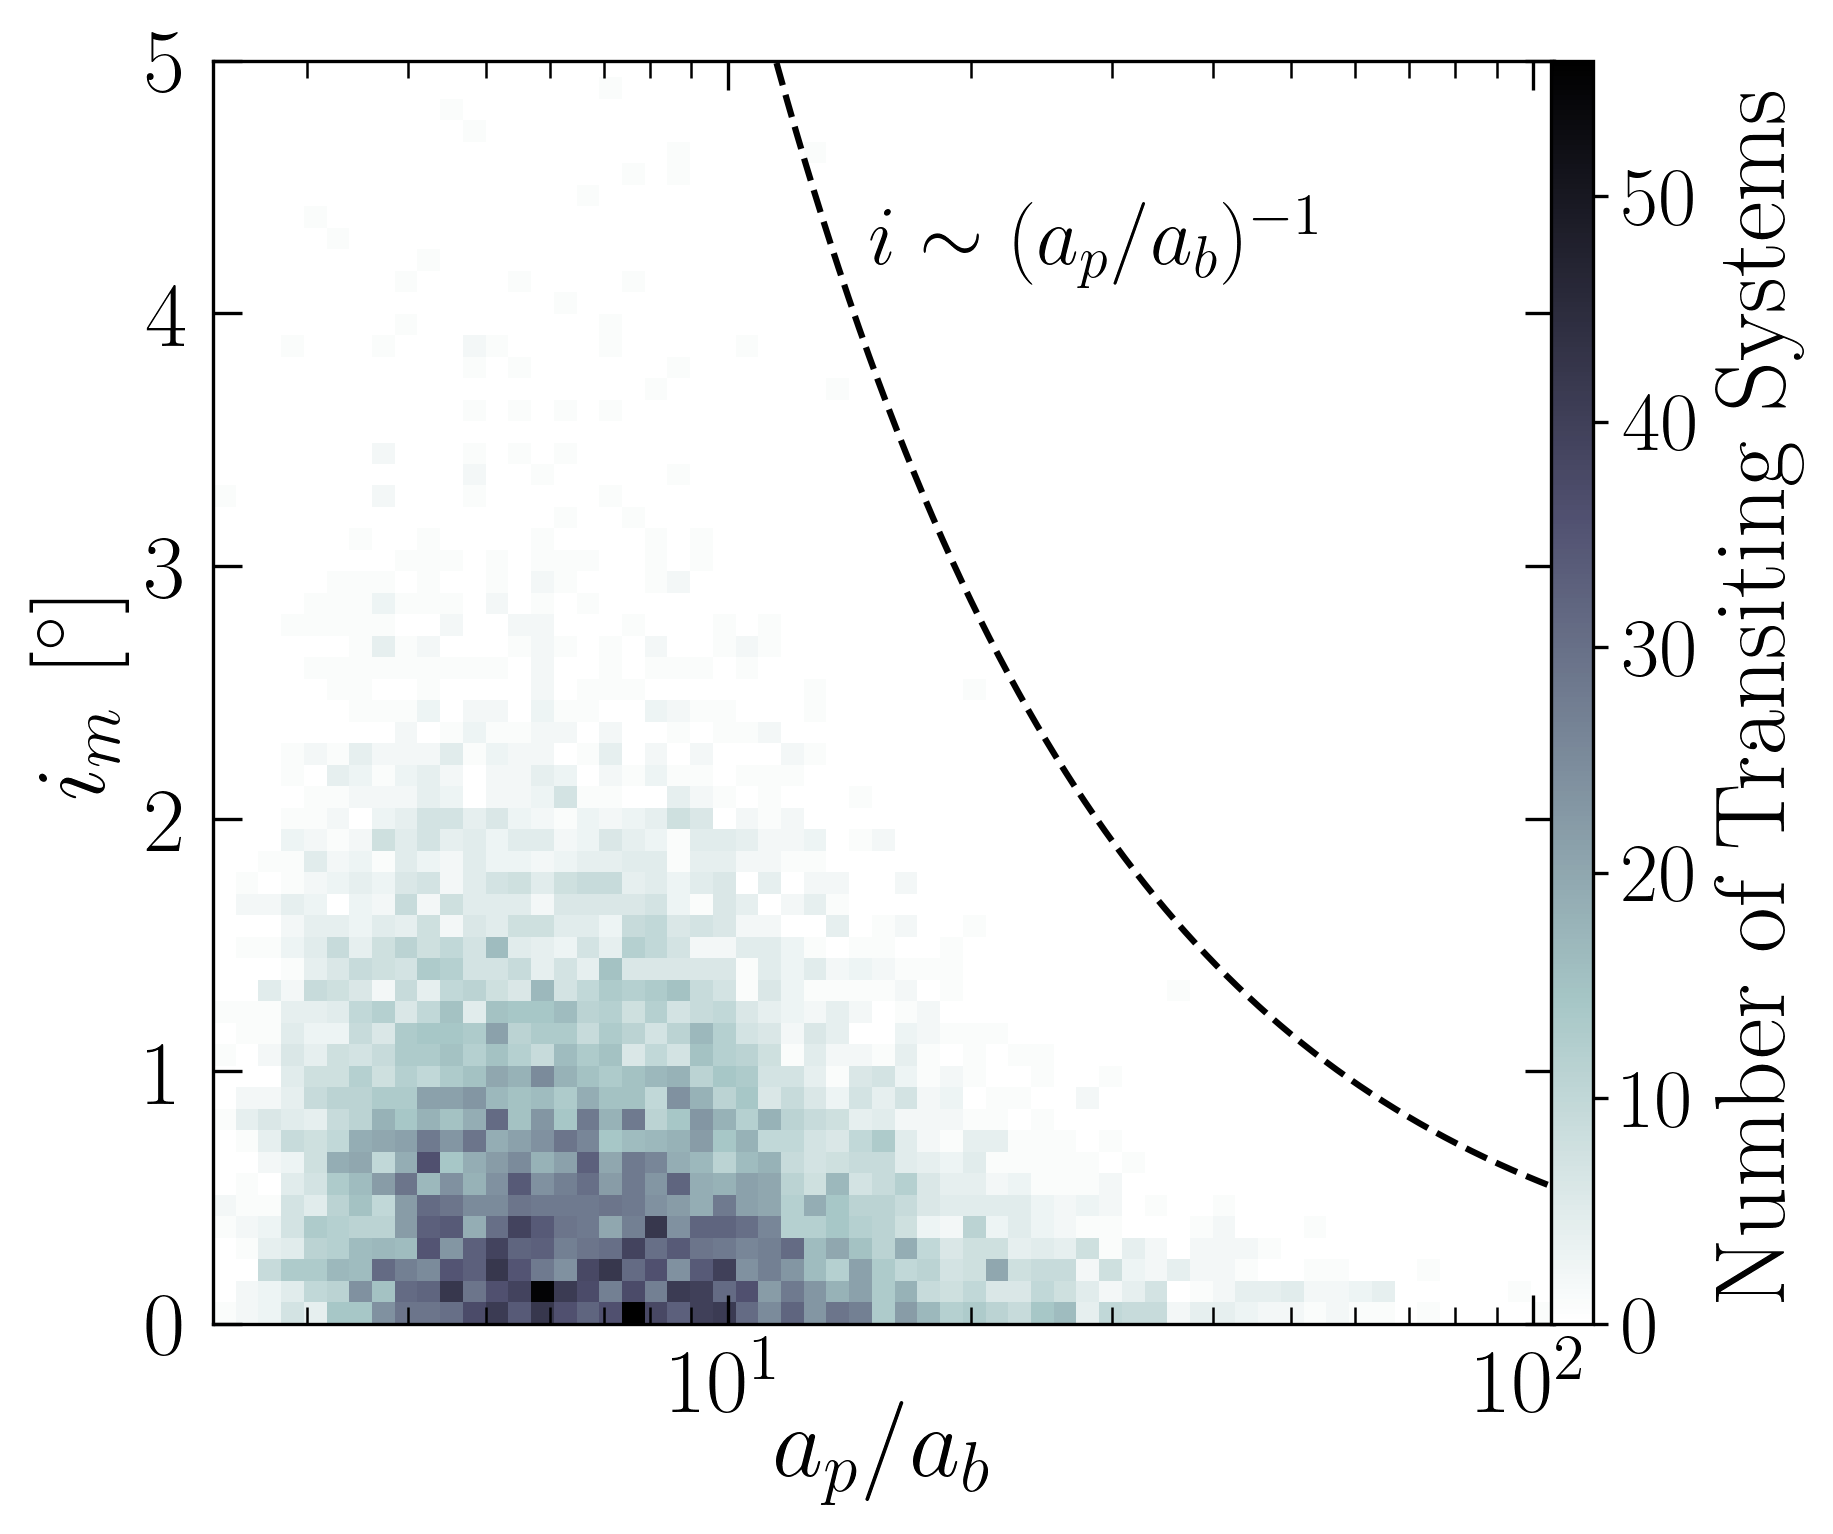

In [165]:
fs = 24
df = pd.concat(read_df(f'data/{f}') 
               for f in os.listdir('data') 
               if f[-4] == '0')

df = df[df.Transit_Value == 2]

norm = plt.cm.colors.Normalize(vmin=0)
cmap = plt.cm.get_cmap('bone_r')
sc = plt.cm.ScalarMappable(norm=norm, cmap=cmap)

fig, ax = plt.subplots(1, 1, layout='constrained', figsize=(6, 5))

R = df.Radius_A + df.Radius_B
a = df.Binary_Semimajor_Axis
e = df.Binary_Eccentricity
p = df.Binary_Period
omega = np.deg2rad([i for i in df.Binary_omega.values])
ecosw = e*np.cos(omega)
corr = (1-np.abs(ecosw))/(1-e**2)
eclipsing = (df.Binary_Inclination-np.pi/2) <= R/a * corr
df = df[eclipsing]

x = df.Planet_Semimajor_Axis/df.Binary_Semimajor_Axis
plot = np.ones_like(x, dtype=bool)
y = abs(df.Planet_Sky_Inclination - df.Binary_Inclination)
y = np.rad2deg(np.array([i for i in y.values]))

bins = (np.logspace(np.log10(x.min()), np.log10(x.max()), 60), 100)
hist, _, _, _ = ax.hist2d(x[plot], y[plot], bins=bins, cmap=cmap, norm=norm)

ax.tick_params(labelsize=fs)
x = np.linspace(x.min(), x.max(), 1_000)
ax.plot(x, np.rad2deg(1/x), 'k--')
ax.text(15, 4.2, r'$i\sim (a_p/a_b)^{-1}$', 
        ha='left', fontsize=fs-4)
ax.set_xscale('log')
ax.set_xlabel('$a_p/a_b$', fontsize=fs, labelpad=-7)
ax.set_ylim(0, 5)
ax.set_ylabel('$i_m$ [$^\circ$]', fontsize=fs)
ax.tick_params(axis='both', direction='in', 
               top=True, bottom=True, 
               left=True, right=True, 
               labelsize=fs-2, which='major',
               length=7, pad=6)
ax.tick_params(axis='both', direction='in', 
               top=True, bottom=True, 
               left=True, right=True, 
               labelsize=fs-2, which='minor',
               length=4)

cbar = fig.colorbar(sc, ax=ax, aspect=30, pad=-0.03)
cbar.set_label(label='Number of Transiting Systems', fontsize=fs)
cbar.ax.tick_params(axis='y', labelsize=fs-4)

plt.show()

In [17]:
def display(files, nbins=50):
    if not isinstance(files, list): files = [files]
    n = len(files)
    fig, ax = plt.subplots(2, 5, sharex=True, sharey=True, 
                           layout='constrained', figsize=(40,7))
    ax = ax.flatten()

    for file, axis in zip(files, ax):
        file = './data/' + file
        with pd.HDFStore(file) as hdf:
            key = 'data'
            df = hdf[key]
            metadata = hdf.get_storer(key).attrs.metadata

        df = df.fillna(value=np.nan)
        R = df.Radius_A + df.Radius_B
        a = df.Binary_Semimajor_Axis
        e = df.Binary_Eccentricity
        i = np.rad2deg(df.Binary_Inclination)-90
        p = df.Binary_Period
        pi = df.Initial_Binary_Period
        pf = df.Final_Binary_Period
        omega = np.deg2rad(df.Binary_omega)
        ecosw = e * np.cos(omega)
        corr = (1-np.abs(ecosw))/(1-e**2)

        eclipsing = abs(np.sin(np.deg2rad(i))) <= R/a * corr
        stable = df.Transit_Value >= 0
        transiting = df.Transit_Value == 2

        plt1 = p[~eclipsing & transiting]
        plt2 = p[eclipsing & stable]
        # print(np.count_nonzero(transiting & ~eclipsing))

        logbins = np.logspace(np.log10(np.amin(np.concatenate((plt1,plt2,)))), 
                              np.log10(np.amax(np.concatenate((plt1,plt2,)))), nbins)
        # linbins = np.linspace(np.amin(np.concatenate((plt2,plt1,))), 
        #                       np.amax(np.concatenate((plt1,plt2,))), nbins)
        bins = logbins
        axis.hist(plt1, bins, label=f'Transiting ({plt1.size})', 
                  histtype='step', color='r', lw=1.5, density=True)
        axis.hist(plt2, bins, label=f'Eclipsing ({plt2.size})',
                  histtype='step', color='k', lw=1.5, density=True)
        axis.axvline(6, ls='--')
        axis.set_title(r'$N$ = ' + str(metadata['N'])
                       + r'$\ \vert\ \eta$ = ' + str(metadata['eta'])
                       + r'$\ \vert\ \alpha$ = ' + str(metadata['alpha'])
                       + r'$\ \vert\ \sigma_{\Delta i}$ = '+str(metadata['sigma_di'])
                       , fontsize=22)
        axis.tick_params(labelsize=15)
        if bins is logbins:
            axis.set_xscale('log')
        axis.legend(loc=1, fontsize=15)
    
    fig.suptitle('Distribution of Eclipsing Binary Periods', fontsize=30)
    fig.supylabel('Number of Detected Planets', fontsize=22)
    fig.supxlabel('$P_b$ [days]', fontsize=22)
    plt.show()

files = os.listdir('data')
# display(files)

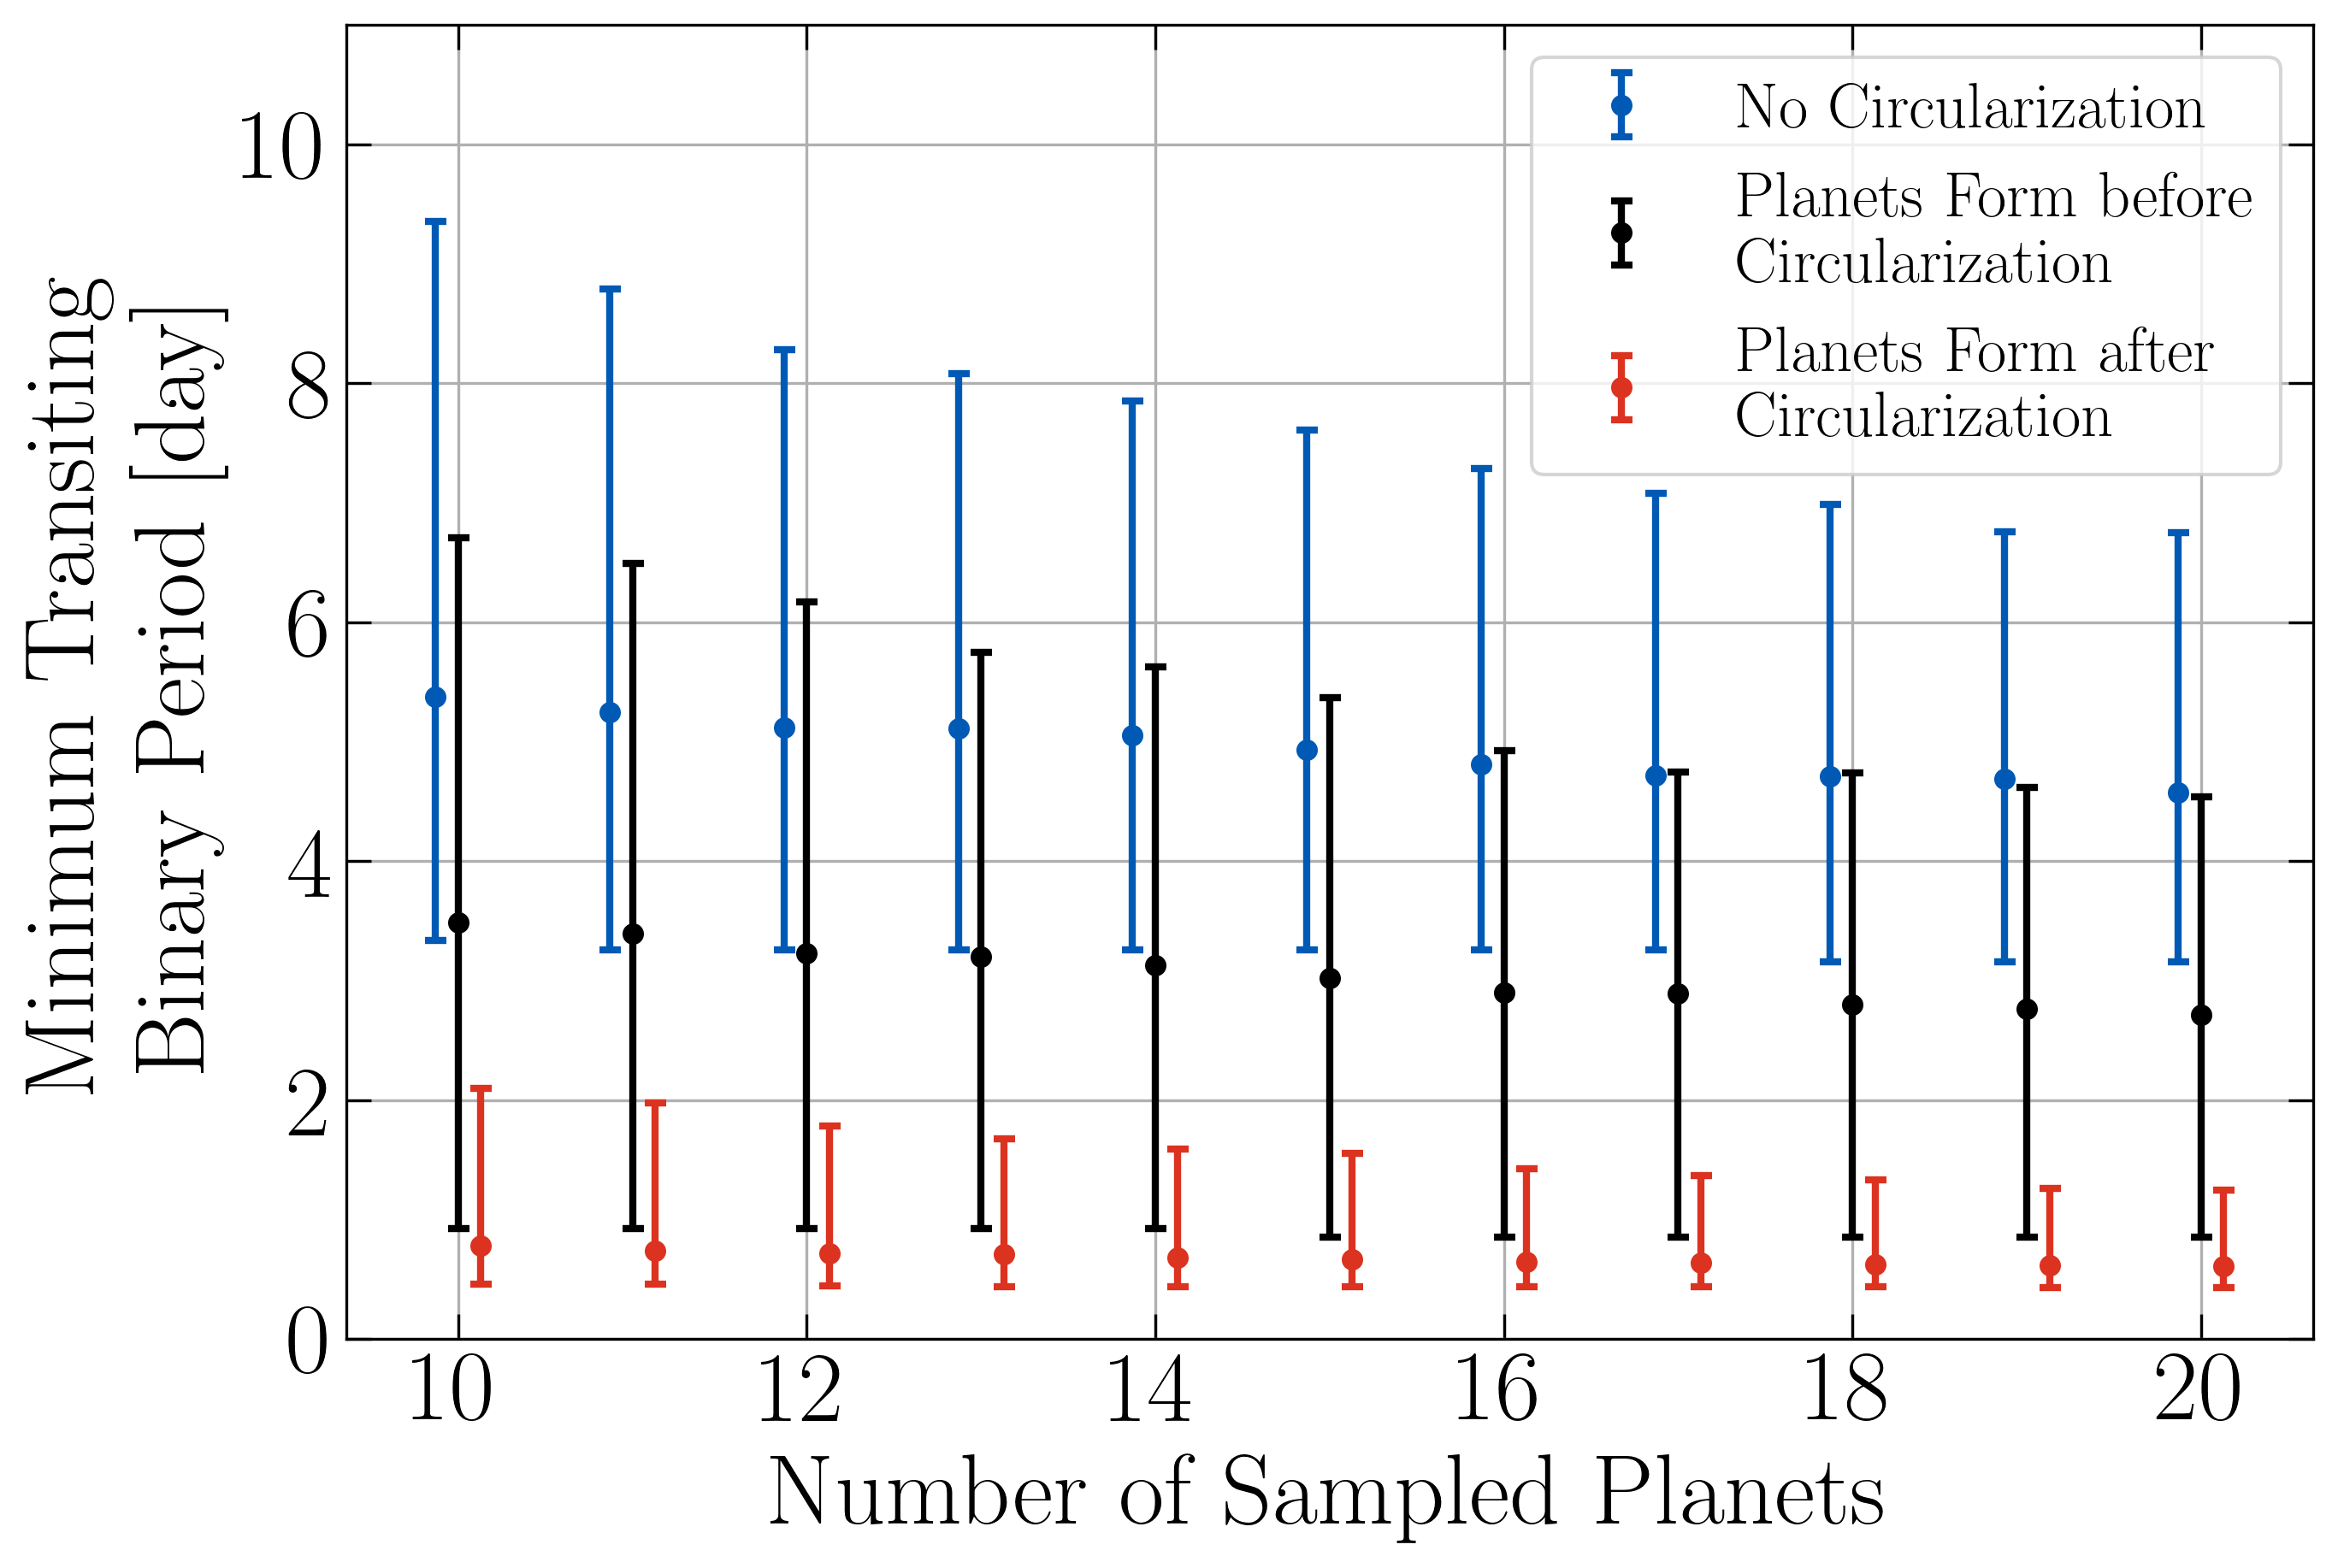

In [159]:
fs = 28
n_samps = np.arange(10, 21)
offset = 0.13
N = 10_000
locs3 = np.arange(-offset, 1.5*offset, offset)
locs4 = np.arange(-1.5*offset, 2*offset, offset)
colors = (color_A, 'k', color_B, color_C)

files = files_control
labels = hist_titles_control
offsets = locs3

fig, ax = plt.subplots(1, 1, layout='constrained', figsize=(9, 6))
for file, label, offset, color in zip(files, labels, offsets, colors):
    df = read_df(file)
    df = df.fillna(value=np.nan)
    df = df[df.Transit_Value == 2]

    R = df.Radius_A + df.Radius_B
    a = df.Binary_Semimajor_Axis
    e = df.Binary_Eccentricity
    p = df.Binary_Period
    ecosw = e*np.cos(np.deg2rad([i for i in df.Binary_omega.values]))
    corr = (1-np.abs(ecosw))/(1-e**2)
    eclipsing = abs(df.Binary_Inclination-np.pi/2) <= R/a * corr
    df = df[eclipsing]
    periods = df.Binary_Period
    idxs = df.index
    def compute_min_period(_):
        rng = np.random.default_rng(_)
        idx = rng.choice(idxs, n, replace=False)
        return np.min(periods[idx])
    min_period_dist = []
    for n in n_samps:
        if N > 100:
            with Pool() as pool:
                min_period = pool.map(compute_min_period, range(N))
        else:
            min_period = list(map(compute_min_period, range(N)))
        min_period_dist.append(np.percentile(min_period, (5, 50, 95)))

    low, mid, hi = np.array(min_period_dist).T
    yerr = (mid-low, hi-mid)
    ax.errorbar(n_samps+offset, mid, yerr=yerr, fmt='o', capsize=3, 
                markersize=5, lw=2, label=label, c=color, capthick=2)
ax.tick_params(axis='both', direction='in', 
               top=True, bottom=True, 
               left=True, right=True, 
               labelsize=fs, which='both', 
               length=7)
ax.legend(fontsize=18, loc=1)
ax.set_ylim(0, 11)
ax.grid(True)

ax.set_xlabel('Number of Sampled Planets', fontsize=fs)
ax.set_ylabel('Minimum Transiting\nBinary Period [day]', fontsize=fs)
plt.show()

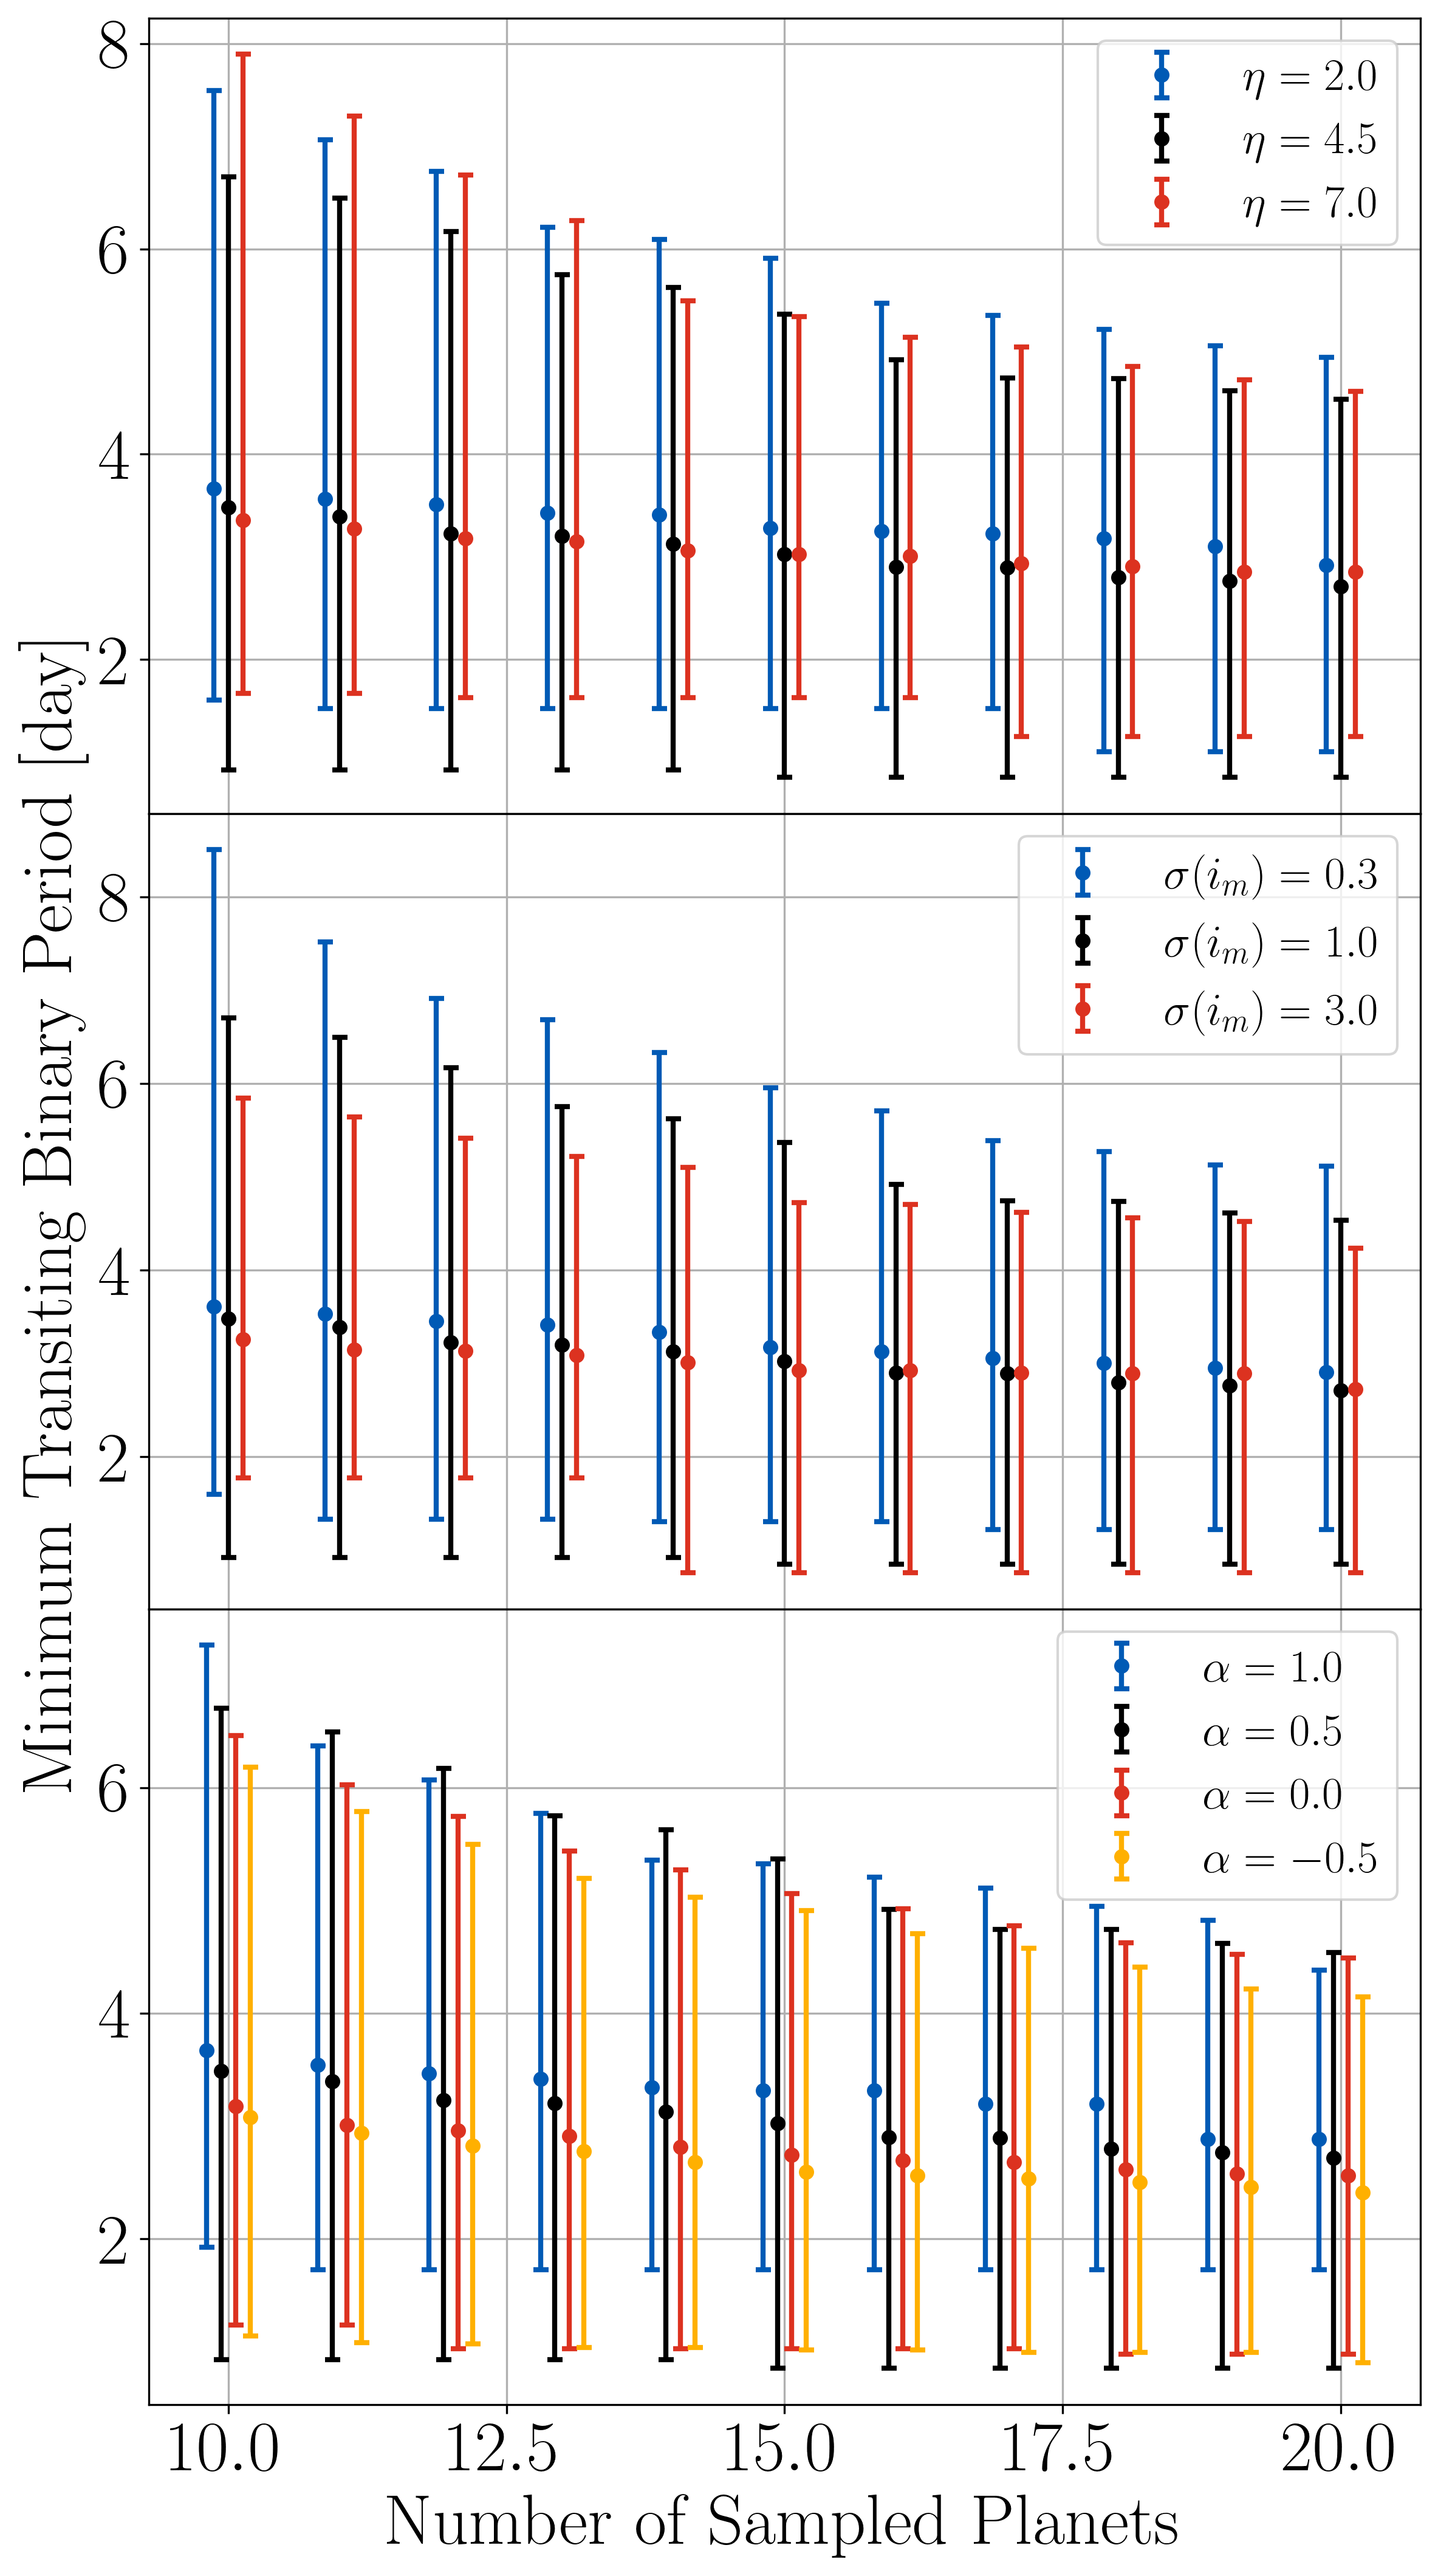

In [163]:
n_samps = np.arange(10, 21)
offset = 0.13
N = 10_000

locs3 = np.arange(-offset, 1.5*offset, offset)
locs4 = np.arange(-1.5*offset, 2*offset, offset)
colors = (color_A, 'k', color_B, color_C)

files = (files_eta, files_sigma, files_alpha)
labels = (hist_titles_eta, hist_titles_sigma, hist_titles_alpha)
offsets = (locs3, locs3, locs4)

fig = plt.figure(figsize=(9, 17))
gs = fig.add_gridspec(len(files), hspace=0)
axes = gs.subplots(sharex=True)

for ax, _files, _labels, _offsets in zip(axes, files, labels, offsets):
    for file, label, offset, color in zip(_files, _labels, _offsets, colors):
        df = read_df(file)
        df = df.fillna(value=np.nan)
        df = df[df.Transit_Value == 2]

        R = df.Radius_A + df.Radius_B
        a = df.Binary_Semimajor_Axis
        e = df.Binary_Eccentricity
        p = df.Binary_Period
        ecosw = e*np.cos(np.deg2rad([i for i in df.Binary_omega.values]))
        corr = (1-np.abs(ecosw))/(1-e**2)
        eclipsing = abs(df.Binary_Inclination-np.pi/2) <= R/a * corr
        df = df[eclipsing]

        periods = df.Binary_Period
        idxs = df.index
        def compute_min_period(_):
            rng = np.random.default_rng(_)
            idx = rng.choice(idxs, n, replace=False)
            return np.min(periods[idx])
        
        min_period_dist = []
        for n in n_samps:
            if N > 100:
                with Pool() as pool:
                    min_period = pool.map(compute_min_period, range(N))
            else:
                min_period = list(map(compute_min_period, range(N)))
            min_period_dist.append(np.percentile(min_period, (5, 50, 95)))

        low, mid, hi = np.array(min_period_dist).T
        yerr = (mid-low, hi-mid)
        ax.errorbar(n_samps+offset, mid, yerr=yerr, fmt='o', capsize=3, 
                    markersize=5, lw=2, label=label, c=color, capthick=2)
    ax.tick_params(labelsize=fs)
    ax.legend(fontsize=18)
    ax.grid()
axes[2].set_xlabel('Number of Sampled Planets', fontsize=fs)
axes[1].set_ylabel('Minimum Transiting Binary Period [day]', fontsize=fs)
plt.show()